# Assignment 3

### Venkata Buddha Work

In [47]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

import time

from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold # Important new include
from torch.utils.data import DataLoader, TensorDataset

import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)
torch.manual_seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Utility Functions

In [48]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['m'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl) - 1
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
    
    return X, labels

In [49]:
def plot_distribution(X, labels):
    ax_raw.scatter(X[labels == 0, 0], X[labels == 0, 1], X[labels == 0, 2], c='r',marker='o', label="Class 0")
    ax_raw.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], c='g',marker='^', label="Class 1")
    ax_raw.scatter(X[labels == 2, 0], X[labels == 2, 1], X[labels == 2, 2], c='b',marker='+', label="Class 2")
    ax_raw.scatter(X[labels == 3, 0], X[labels == 3, 1], X[labels == 3, 2], c='y',marker='*', label="Class 3")
    ax_raw.set_xlabel(r"$x_1$")
    ax_raw.set_ylabel(r"$x_2$")
    ax_raw.set_zlabel(r"$x_3$")
    # Set equal axes for 3D plots
    ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

    plt.title("Data & True Class Labels for N = {}".format(np.size(X, axis=0)))
    plt.legend()
    plt.tight_layout()
    plt.show()

## Classifiers

In [50]:
# ERM classification rule (min prob. of error classifier)
def perform_erm_classification(X, Lambda, gmm_params, C):
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['m'][c], gmm_params['C'][c]) for c in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    return np.argmin(risk_mat, axis=0)

## Generate data
For C = 4 classes with uniform priors, specify Gaussian class-conditional
pdfs for a 3-dimensional real-valued random vector x. Pick your own mean vectors and covariance
matrices for each class. Adjust these parameters of the multivariate Gaussian distribution so that
the MAP classifier achieves between 10%−20% probability of error when using the true data pdf.

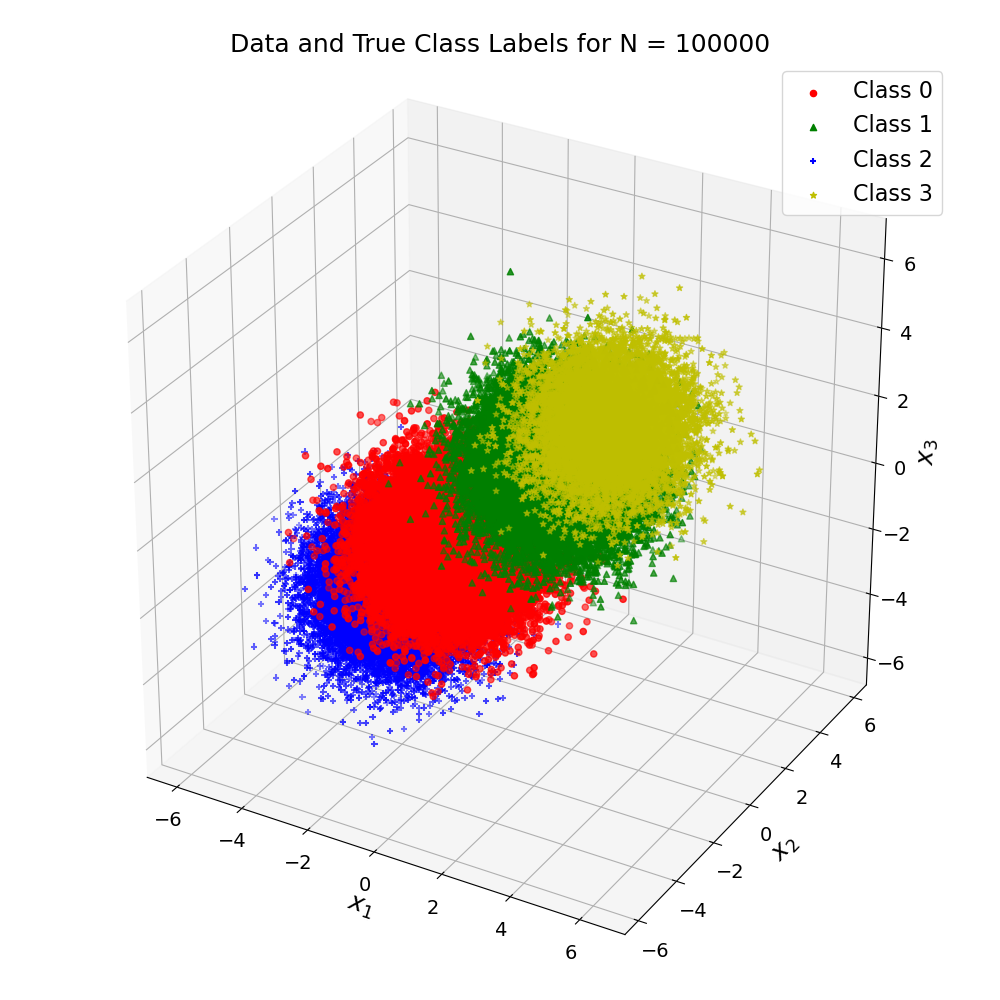

In [51]:
# Generate dataset from two different 3D Gaussian distributions/categories
gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.3, 0.3, 0.3, 0.3])
num_classes = len(gmm_pdf['priors'])
L = np.array(range(num_classes))
C = np.size(L)

# # Mean and covariance of data pdfs conditioned on labels
gmm_pdf['m'] = np.array([[-1, -1, -1],
                         [1, 1, 1],
                         [-2, -2, -2],
                         [2, 2, 2]])  # Gaussian distributions means
gmm_pdf['C'] = np.array([np.identity(3), np.identity(3), np.identity(3), np.identity(3)])  # Gaussian distributions covariance matrices

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
ax_raw = fig.add_subplot(111, projection='3d')

N = 100000

X, labels = generate_data_from_gmm(N, gmm_pdf)

plot_distribution(X, labels)

## Multilayer Neural Network

Let's now use [PyTorch](https://pytorch.org/) and put together an MLP that will be capable of separating the classes irrespective of the input's non-linearly separable space.

To begin with, we'll define an MLP class that consists of a single hidden layer (2-layer architecture altogether) with a ReLU activation function:

In [52]:
input_dim = X.shape[1]
n_hidden_neurons = 16 # <-- vary this
output_dim = C

# It's called an MLP but really it's not...
model = nn.Sequential(
    nn.Linear(input_dim, n_hidden_neurons),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons, output_dim),
    nn.LogSoftmax(dim=1)
)
# Visualize network architecture
print(model)
summary(model, input_size=(16, input_dim))

Sequential(
  (0): Linear(in_features=3, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=4, bias=True)
  (3): LogSoftmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 16]              64
              ReLU-2               [-1, 16, 16]               0
            Linear-3                [-1, 16, 4]              68
        LogSoftmax-4                [-1, 16, 4]               0
Total params: 132
Trainable params: 132
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [53]:
def model_train(model, data, labels, criterion, optimizer, num_epochs=25):
    # Apparently good practice to set this "flag" too before training
    # Does things like make sure Dropout layers are active, gradients are updated, etc.
    # Probably not a big deal for our toy network, but still worth developing good practice
    model.train()
    # Optimize the neural network
    for epoch in range(num_epochs):
        # These outputs represent the model's predicted probabilities for each class. 
        outputs = model(data)
        # Criterion computes the cross entropy loss between input and target
        loss = criterion(outputs, labels)
        # Set gradient buffers to zero explicitly before backprop
        optimizer.zero_grad()
        # Backward pass to compute the gradients through the network
        loss.backward()
        # GD step update
        optimizer.step()
        
    return model


# Stochastic GD with learning rate and momentum hyperparameters
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# The nn.CrossEntropyLoss() loss function automatically performs a log_softmax() to 
# the output when validating, on top of calculating the negative log-likelihood using 
# nn.NLLLoss(), while also being more stable numerically... So don't implement from scratch
criterion = nn.CrossEntropyLoss()
num_epochs = 25

# Convert numpy structures to PyTorch tensors, as these are the data types required by the library
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(labels)

# Trained model
model = model_train(model, X_tensor, y_tensor, criterion, optimizer, num_epochs=num_epochs)

Probability of error:

In [54]:
def p_error(decisions, labels):
    print("Confusion Matrix :")
    conf_mat = confusion_matrix(decisions, labels)
    print(conf_mat)

    correct_class_samples = np.sum(np.diag(conf_mat))
    print("Total Misclassified Samples: {:d}".format(len(decisions) - correct_class_samples))

    prob_error = 1 - (correct_class_samples / len(decisions))
    print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))
    return prob_error

In [55]:
# ERM decisions:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((C, C)) - np.eye(C)

decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

print('MAP classifier:')
p_optimal = p_error(decisions, labels)

MAP classifier:
Confusion Matrix (rows: Predicted class, columns: True class):
[[23093  1208  5888     4]
 [ 1236 22832     7  2049]
 [ 5830     0 24103     0]
 [    0  5754     0  7996]]
Total Mumber of Misclassified Samples: 21976
Empirically Estimated Probability of Error: 0.2198


In [57]:
def model_train_loader(model, dataloader, criterion, optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        predictions = model(X)
        loss = criterion(predictions, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
            
def model_test_loader(model, dataloader, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    # Tracking test loss (cross-entropy) and correct classification rate (accuracy)
    test_loss, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            predictions = model(X)
            test_loss += criterion(predictions, y)
            correct += (predictions.argmax(1) == y).type(torch.float).sum()
            
    test_loss /= num_batches
    correct /= size

In [58]:
def k_fold_analysis(N_train, N_valid, K, max_num_perceptrons):
    X_train, y_train = generate_data_from_gmm(N_train, gmm_pdf)
    X_valid, y_valid = generate_data_from_gmm(N_valid, gmm_pdf)

    input_dim = X_train.shape[1]
    output_dim = C

    # Perceptrons to evaluate 
    perceptrons = np.arange(1, max_num_perceptrons, dtype=int)
    n_perceptrons_evaluated = np.size(perceptrons)

    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    # Shuffles data before doing the division into folds (not necessary, but a good idea)
    kf = KFold(n_splits=K, shuffle=True) 

    # Allocate space for CV
    # No need for training loss storage too but useful comparison
    error_train_mk = np.empty((n_perceptrons_evaluated, K)) 
    error_valid_mk = np.empty((n_perceptrons_evaluated, K)) 

    index = 0
    # STEP 2: Try all polynomial orders between 1 (best line fit) and 21 (big time overfit) M=2
    for perceptron in perceptrons:

        n_hidden_neurons = perceptron # <-- vary this

        # K-fold cross validation
        k = 0
        # NOTE that these subsets are of the TRAINING dataset
        # Imagine we don't have enough data available to afford another entirely separate validation set
        for train_indices, valid_indices in kf.split(X_train):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X_train[train_indices]
            y_train_k = y_train[train_indices]
            X_valid_k = X_valid[valid_indices]
            y_valid_k = y_valid[valid_indices]
            
            # Train model parameters

            # Convert numpy structures to PyTorch tensors, as these are the data types required by the library
            X_train_k_tensor = torch.FloatTensor(X_train_k)
            y_train_k_tensor = torch.LongTensor(y_train_k)
            X_valid_k_tensor = torch.FloatTensor(X_valid_k)
            y_valid_k_tensor = torch.LongTensor(y_valid_k)

            # Create your dataset objects
            train_data = TensorDataset(X_train_k_tensor,  y_train_k_tensor) 
            test_data = TensorDataset(X_valid_k_tensor, y_valid_k_tensor) 

            train_dataloader = DataLoader(train_data, batch_size=500, shuffle=True)
            test_dataloader = DataLoader(test_data, batch_size=64) # No need to shuffle...

            model = nn.Sequential(
                nn.Linear(input_dim, n_hidden_neurons),
                nn.ReLU(),
                nn.Linear(n_hidden_neurons, output_dim),
                nn.LogSoftmax(dim=1)
            )
            
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
            for t in range(num_epochs):
                # print(f"Epoch {t+1}\n-------------------------------")
                model_train_loader(model, train_dataloader, criterion, optimizer)
                model_test_loader(model, test_dataloader, criterion)

            # Trained model
            Z_probs_train = model(X_train_k_tensor).detach().numpy()
            Z_pred_train = np.argmax(Z_probs_train, 1)

            Z_probs_valid = model(X_valid_k_tensor).detach().numpy()
            Z_pred_valid = np.argmax(Z_probs_valid, 1)

            # Record error as well for this model and k-fold
            error_train_mk[index, k] = p_error(Z_pred_train, y_train_k)
            error_valid_mk[index, k] = p_error(Z_pred_valid, y_valid_k)
            k += 1
        index += 1

                
    # STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
    # mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
    error_train_m = np.mean(error_train_mk, axis=1) 
    error_valid_m = np.mean(error_valid_mk, axis=1) 

    # +1 as the index starts from 0 while the degrees start from 1
    optimal_perceptron = perceptrons[np.argmin(error_valid_m)]
    # print('The best number of perceptrons is p ={}'.format(optimal_perceptron))

    return error_train_m, error_valid_m, perceptrons, optimal_perceptron


Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1 26  0  7]
 [ 0  0  0  0]
 [25  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 58
Empirically Estimated Probability of Error: 0.6444
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 4 0 1]
 [0 0 0 0]
 [2 0 3 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 7
Empirically Estimated Probability of Error: 0.7000
Confusion Matrix (rows: Predicted class, columns: True class):
[[16  0 28  0]
 [ 5 26  1  7]
 [ 6  0  1  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 47
Empirically Estimated Probability of Error: 0.5222
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 2 0]
 [1 4 0 1]
 [1 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [28 25 30  7]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 65


Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 2 25  0  5]
 [26  1 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 34
Empirically Estimated Probability of Error: 0.3778
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [1 0 0 2]
 [2 1 4 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.6000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 8  7  0  0]
 [ 2 20  0  7]
 [15  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3444
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 2 0 0]
 [0 2 0 1]
 [4 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 7
Empirically Estimated Probability of Error: 0.7000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  3  0]
 [ 0  0  0  0]
 [26 24 27  7]
 [ 0  3  0  0]]
Total Mumber of Misclassified Samples: 63


 [3 0 2]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[11  0  6  0]
 [ 1 22  0  6]
 [14  4 26  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3444
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0]
 [0 4 0]
 [3 0 3]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  0  0  0]
 [ 1 26  0  7]
 [22  1 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3444
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 3 0 0]
 [3 0 3 1]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  1  0  0]
 [ 

[[ 9  2  0  0]
 [ 1 24  0  7]
 [17  0 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 5 0 2]
 [2 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  0  0  0]
 [ 1 25  0  6]
 [23  1 33  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3444
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 2 0 1]
 [4 1 2 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.6000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 1 26  0  5]
 [27  1 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 34
Empirically Estimated Probability of Error: 0.3778
Confusion Ma

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 6  2  0  0]
 [ 2 23  0  7]
 [20  0 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3444
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 1 0 0]
 [0 2 0 1]
 [2 0 4 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  1  0  0]
 [ 1 22  0  7]
 [25  1 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 35
Empirically Estimated Probability of Error: 0.3889
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0 0]
 [0 5 0 1]
 [2 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[11  1  0  0]
 [ 0 25  0  6]
 [17  0 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24


Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  0  0  0]
 [ 2 25  0  7]
 [23  1 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 33
Empirically Estimated Probability of Error: 0.3667
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0]
 [0 2 0]
 [4 0 4]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 7  0  0  0]
 [ 1 26  0  5]
 [18  1 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.2778
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0 0]
 [0 2 0 1]
 [0 1 5 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 2
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 8  0  0  0]
 [ 3 25  0  5]
 [18  1 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estim

[[ 5  1  0  0]
 [ 1 26  0  6]
 [22  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 30
Empirically Estimated Probability of Error: 0.3333
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 3 0 2]
 [2 0 3 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 2 26  0  7]
 [23  1 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 33
Empirically Estimated Probability of Error: 0.3667
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 4 0 2]
 [3 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  5  1  0]
 [ 1 22  0  7]
 [17  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3444
Confusion Ma

[[ 0  0  0  0]
 [ 2 28  0  7]
 [21  0 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 30
Empirically Estimated Probability of Error: 0.3333
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 2 0 3]
 [2 0 3 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  1  1  0]
 [ 0 27  0  7]
 [17  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 1 0]
 [0 3 0]
 [4 0 1]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[12  1  1  0]
 [ 1 25  0  5]
 [14  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 22
Empirically Estimated Probability of Error: 0.2444
Confusion Matrix (rows: Predi

[[0 0 0 0]
 [0 0 0 2]
 [2 0 6 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 8  0  3  0]
 [ 1 28  0  6]
 [19  0 25  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 29
Empirically Estimated Probability of Error: 0.3222
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 7 0 1]
 [1 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 2
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 5  0  0  0]
 [ 1 23  0  7]
 [21  1 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 30
Empirically Estimated Probability of Error: 0.3333
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0]
 [0 2 0]
 [3 0 5]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, colum

[[ 5  1  0  0]
 [ 1 25  0  7]
 [21  0 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 30
Empirically Estimated Probability of Error: 0.3333
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 1 0 1]
 [3 0 5 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 4  0  0  0]
 [ 4 24  0  7]
 [19  0 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 30
Empirically Estimated Probability of Error: 0.3333
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 1 0]
 [0 1 0]
 [1 0 6]]
Total Mumber of Misclassified Samples: 2
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 6  0  0  0]
 [ 2 26  0  7]
 [16  1 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predi

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 6  0  0  0]
 [ 2 27  0  7]
 [17  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 1 0]
 [0 3 0 2]
 [2 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[10  1  1  0]
 [ 2 24  0  6]
 [15  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.2778
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 1 0 0]
 [0 4 0 1]
 [1 0 3 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[12  0  2  0]
 [ 1 27  0  6]
 [15  0 27  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24


Confusion Matrix (rows: Predicted class, columns: True class):
[[13  2  4  0]
 [ 1 24  0  6]
 [15  0 25  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.3111
Confusion Matrix (rows: Predicted class, columns: True class):
[[3 1 0 0]
 [0 4 0 1]
 [0 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 2
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[11  1  0  0]
 [ 1 25  0  6]
 [16  0 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24
Empirically Estimated Probability of Error: 0.2667
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 2 0 0]
 [0 3 0 1]
 [3 0 0 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.6000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 7  0  0  0]
 [ 2 27  0  6]
 [16  1 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25


Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  0  2  0]
 [ 2 26  0  6]
 [17  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0]
 [0 5 0]
 [5 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[13  1  2  0]
 [ 1 26  0  6]
 [14  0 27  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24
Empirically Estimated Probability of Error: 0.2667
Confusion Matrix (rows: Predicted class, columns: True class):
[[2 0 0 0]
 [0 2 0 2]
 [2 0 2 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[10  0  1  0]
 [ 1 28  0  7]
 [14  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 23
Empirically Estim

[[11  1  0  0]
 [ 2 24  0  7]
 [14  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24
Empirically Estimated Probability of Error: 0.2667
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 1 0 0]
 [0 4 0 3]
 [2 0 0 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.6000
Confusion Matrix (rows: Predicted class, columns: True class):
[[11  1  3  0]
 [ 1 26  0  6]
 [15  0 27  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0 0]
 [0 3 0 2]
 [1 0 3 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[11  1  3  0]
 [ 0 24  0  7]
 [16  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.3000
Confusion Ma

[[ 9  1  4  0]
 [ 3 24  0  6]
 [14  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.3111
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0]
 [0 3 0]
 [1 0 6]]
Total Mumber of Misclassified Samples: 1
Empirically Estimated Probability of Error: 0.1000
Confusion Matrix (rows: Predicted class, columns: True class):
[[12  0  3  0]
 [ 2 26  0  6]
 [15  0 26  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 1 0]
 [0 3 0]
 [2 0 3]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  1  1  0]
 [ 2 25  0  7]
 [13  0 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24
Empirically Estimated Probability of Error: 0.2667
Confusion Matrix (rows: Predicted class, colum

Confusion Matrix (rows: Predicted class, columns: True class):
[[12  1  2  0]
 [ 1 25  0  6]
 [15  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.2778
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 1 0 0]
 [0 2 0 1]
 [2 0 4 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 7  1  0  0]
 [ 1 24  0  7]
 [18  0 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0 0]
 [0 3 0 2]
 [3 0 1 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[14  1  2  0]
 [ 2 26  0  6]
 [10  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 21


[[13  1  4  0]
 [ 1 23  0  6]
 [16  0 26  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.3111
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 1 0 0]
 [0 2 0 3]
 [2 0 2 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.6000
Confusion Matrix (rows: Predicted class, columns: True class):
[[11  1  0  0]
 [ 1 25  0  6]
 [15  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 23
Empirically Estimated Probability of Error: 0.2556
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0]
 [0 2 0]
 [2 0 5]]
Total Mumber of Misclassified Samples: 2
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[12  1  2  0]
 [ 1 24  0  7]
 [15  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predi

Confusion Matrix (rows: Predicted class, columns: True class):
[[10  1  1  0]
 [ 3 27  0  5]
 [12  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 22
Empirically Estimated Probability of Error: 0.2444
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0 0]
 [1 2 0 1]
 [3 0 2 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[10  1  3  0]
 [ 1 22  0  7]
 [17  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 29
Empirically Estimated Probability of Error: 0.3222
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 1 0]
 [0 3 0]
 [3 0 2]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[12  1  3  0]
 [ 1 25  0  6]
 [13  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24
Empirically Estim

 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 22
Empirically Estimated Probability of Error: 0.2444
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0 0]
 [0 3 0 2]
 [1 0 3 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 7  1  0  0]
 [ 1 26  0  6]
 [17  0 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.2778
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 1 0 0]
 [1 2 0 1]
 [1 0 4 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[13  1  4  0]
 [ 3 25  0  7]
 [13  0 24  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.3111
Confusion Matrix (rows: Predicted class, columns: True cl

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 0  0  0  2]
 [55  6 49  0]
 [ 0 46  0 22]]
Total Mumber of Misclassified Samples: 109
Empirically Estimated Probability of Error: 0.6056
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 0 0 1]
 [4 0 9 0]
 [0 3 0 3]]
Total Mumber of Misclassified Samples: 8
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [36 53 17 23]
 [16  1 34  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 93
Empirically Estimated Probability of Error: 0.5167
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [3 4 0 3]
 [2 0 8 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 8
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[16 50  3 26]
 [ 0  0  0  0]
 [37  0 48  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 11

[[ 1  0  0  0]
 [ 6 48  1 27]
 [47  2 48  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 83
Empirically Estimated Probability of Error: 0.4611
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0]
 [ 1  2  0]
 [ 6  0 11]]
Total Mumber of Misclassified Samples: 7
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [17 46  8 25]
 [35  6 43  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 91
Empirically Estimated Probability of Error: 0.5056
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [5 3 0 1]
 [8 0 3 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 14
Empirically Estimated Probability of Error: 0.7000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 5  5  1  0]
 [ 0  0  0  0]
 [50 15 50  0]
 [ 1 29  0 24]]
Total Mumber of Misclassified Samples: 101
Empirically Estimated Probability of Error: 0.5611
Confusion Matrix (

Confusion Matrix (rows: Predicted class, columns: True class):
[[18  2  5  0]
 [ 2 46  0 18]
 [31  1 49  0]
 [ 0  2  0  6]]
Total Mumber of Misclassified Samples: 61
Empirically Estimated Probability of Error: 0.3389
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 0 0]
 [0 4 0 0]
 [4 0 7 0]
 [0 1 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  1  1  0]
 [ 4 50  0 26]
 [47  0 51  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 79
Empirically Estimated Probability of Error: 0.4389
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  0  0  0]
 [ 1  2  0  3]
 [10  0  3  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 14
Empirically Estimated Probability of Error: 0.7000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  0  0  0]
 [ 1 46  0 26]
 [49  2 53  0]
 [ 0  2  0  0]]
Total Mumber of Misclassi

Confusion Matrix (rows: Predicted class, columns: True class):
[[16  1  2  0]
 [ 2 35  0  4]
 [36  0 51  0]
 [ 0 12  0 21]]
Total Mumber of Misclassified Samples: 57
Empirically Estimated Probability of Error: 0.3167
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 0 0]
 [0 2 0 0]
 [6 0 8 0]
 [0 2 0 1]]
Total Mumber of Misclassified Samples: 8
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 1 50  0 26]
 [52  2 49  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 81
Empirically Estimated Probability of Error: 0.4500
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0]
 [1 4 0]
 [9 0 6]]
Total Mumber of Misclassified Samples: 10
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  1  3  0]
 [ 0 53  0 25]
 [41  0 48  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 70
Empirically Esti

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 4  2  0  0]
 [ 1 39  0 10]
 [47  1 53  0]
 [ 0  8  0 15]]
Total Mumber of Misclassified Samples: 69
Empirically Estimated Probability of Error: 0.3833
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 9 0 0]
 [5 0 5 0]
 [0 0 0 1]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[13  5  5  1]
 [ 1 44  0 21]
 [35  1 47  0]
 [ 0  3  0  4]]
Total Mumber of Misclassified Samples: 72
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[5 0 0 0]
 [1 3 0 1]
 [1 0 8 0]
 [0 0 0 1]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.1500
Confusion Matrix (rows: Predicted class, columns: True class):
[[21  5  2  0]
 [ 1 46  0 26]
 [31  0 48  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 65


[[26  0 17  0]
 [ 3 44  0 23]
 [23  1 35  0]
 [ 1  5  0  2]]
Total Mumber of Misclassified Samples: 73
Empirically Estimated Probability of Error: 0.4056
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 4]
 [1 5 0]
 [3 0 3]]
Total Mumber of Misclassified Samples: 8
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[21  1  7  0]
 [ 1 49  0 21]
 [31  1 43  0]
 [ 0  1  0  4]]
Total Mumber of Misclassified Samples: 63
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 0 0]
 [0 5 0 2]
 [4 0 5 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 2 47  0 27]
 [47  4 53  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 80
Empirically Estimated Probability of Error: 0.4444
Confusion Matrix (rows: Predi

[[19  3  5  0]
 [ 2 48  0 26]
 [30  1 46  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 67
Empirically Estimated Probability of Error: 0.3722
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 0 0]
 [0 3 0 2]
 [4 0 7 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[17  2  5  0]
 [ 0 33  0 14]
 [34  0 47  0]
 [ 1 14  0 13]]
Total Mumber of Misclassified Samples: 70
Empirically Estimated Probability of Error: 0.3889
Confusion Matrix (rows: Predicted class, columns: True class):
[[2 0 0 0]
 [0 4 0 0]
 [7 0 5 0]
 [0 2 0 0]]
Total Mumber of Misclassified Samples: 9
Empirically Estimated Probability of Error: 0.4500
Confusion Matrix (rows: Predicted class, columns: True class):
[[23  0  5  0]
 [ 1 50  0 21]
 [28  0 50  0]
 [ 0  0  0  2]]
Total Mumber of Misclassified Samples: 55
Empirically Estimated Probability of Error: 0.3056
Confusion Ma

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 4  0  2  0]
 [ 0 41  0 16]
 [48  0 50  0]
 [ 0 10  0  9]]
Total Mumber of Misclassified Samples: 76
Empirically Estimated Probability of Error: 0.4222
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 4 0 2]
 [6 0 7 0]
 [0 1 0 0]]
Total Mumber of Misclassified Samples: 9
Empirically Estimated Probability of Error: 0.4500
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  0  0  0]
 [ 4 46  1 11]
 [43  0 51  0]
 [ 0  7  0 16]]
Total Mumber of Misclassified Samples: 66
Empirically Estimated Probability of Error: 0.3667
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [2 3 0 1]
 [4 0 8 0]
 [0 1 0 1]]
Total Mumber of Misclassified Samples: 8
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 6  0  1  0]
 [ 2 46  0 21]
 [45  1 51  0]
 [ 0  4  0  3]]
Total Mumber of Misclassified Samples: 74


 [0 0 0 1]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 5  2  1  0]
 [ 0 46  0 23]
 [46  4 53  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 76
Empirically Estimated Probability of Error: 0.4222
Confusion Matrix (rows: Predicted class, columns: True class):
[[2 0 0 0]
 [0 2 0 3]
 [6 1 6 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 10
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[25  1  4  0]
 [ 1 48  0 18]
 [25  0 47  0]
 [ 0  5  0  6]]
Total Mumber of Misclassified Samples: 54
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[1 0 1 0]
 [0 5 0 1]
 [5 0 7 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 7
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True class)

Confusion Matrix (rows: Predicted class, columns: True class):
[[21  1  4  0]
 [ 1 43  0 19]
 [30  1 51  0]
 [ 0  2  0  7]]
Total Mumber of Misclassified Samples: 58
Empirically Estimated Probability of Error: 0.3222
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 1 0]
 [0 7 0 1]
 [1 0 4 0]
 [0 0 0 2]]
Total Mumber of Misclassified Samples: 3
Empirically Estimated Probability of Error: 0.1500
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 8  0  1  0]
 [ 1 45  0 20]
 [40  0 50  0]
 [ 0  7  0  8]]
Total Mumber of Misclassified Samples: 69
Empirically Estimated Probability of Error: 0.3833
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [1 4 0 1]
 [5 0 9 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 7
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  0  1  0]
 [ 0 36  0 16]
 [49  4 52  0]
 [ 0 11  0  9]]
Total Mumber of Misclassified Samples: 81


Confusion Matrix (rows: Predicted class, columns: True class):
[[11  1  6  0]
 [ 1 47  0 24]
 [39  1 48  0]
 [ 0  0  0  2]]
Total Mumber of Misclassified Samples: 72
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[2 1 0 0]
 [0 5 0 2]
 [6 0 4 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 9
Empirically Estimated Probability of Error: 0.4500
Confusion Matrix (rows: Predicted class, columns: True class):
[[26  3  4  0]
 [ 1 49  0 24]
 [27  0 46  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 59
Empirically Estimated Probability of Error: 0.3278
Confusion Matrix (rows: Predicted class, columns: True class):
[[5 1 1]
 [0 7 0]
 [2 0 4]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[20  2  6  0]
 [ 1 50  0 23]
 [29  1 46  0]
 [ 0  0  0  2]]
Total Mumber of Misclassified Samples: 62
Empirically Estim

Confusion Matrix (rows: Predicted class, columns: True class):
[[25  0  9  0]
 [ 5 49  0 20]
 [22  0 42  0]
 [ 0  2  0  6]]
Total Mumber of Misclassified Samples: 58
Empirically Estimated Probability of Error: 0.3222
Confusion Matrix (rows: Predicted class, columns: True class):
[[2 0 0 0]
 [1 7 0 1]
 [2 0 7 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[23  0  7  0]
 [ 1 45  0 10]
 [28  0 46  0]
 [ 0  5  0 15]]
Total Mumber of Misclassified Samples: 51
Empirically Estimated Probability of Error: 0.2833
Confusion Matrix (rows: Predicted class, columns: True class):
[[3 0 0 0]
 [1 2 0 4]
 [3 0 6 0]
 [0 0 0 1]]
Total Mumber of Misclassified Samples: 8
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 4  0  2  0]
 [ 0 53  0 24]
 [45  1 50  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 72


 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 68
Empirically Estimated Probability of Error: 0.3778
Confusion Matrix (rows: Predicted class, columns: True class):
[[0 0 0 0]
 [0 7 0 3]
 [3 0 7 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[27  1  9  0]
 [ 1 48  0 25]
 [25  0 42  0]
 [ 0  1  0  1]]
Total Mumber of Misclassified Samples: 62
Empirically Estimated Probability of Error: 0.3444
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 0 0]
 [1 5 0 4]
 [2 0 4 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 7
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True class):
[[23  6  6  0]
 [ 1 35  0 11]
 [28  0 44  0]
 [ 0 11  0 15]]
Total Mumber of Misclassified Samples: 63
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True cl

Confusion Matrix (rows: Predicted class, columns: True class):
[[21  1  7  0]
 [ 0 41  0 22]
 [29  0 46  0]
 [ 1 10  0  2]]
Total Mumber of Misclassified Samples: 70
Empirically Estimated Probability of Error: 0.3889
Confusion Matrix (rows: Predicted class, columns: True class):
[[3 0 0 0]
 [0 3 0 4]
 [6 0 1 0]
 [0 2 0 1]]
Total Mumber of Misclassified Samples: 12
Empirically Estimated Probability of Error: 0.6000
Confusion Matrix (rows: Predicted class, columns: True class):
[[36  1 12  0]
 [ 1 51  0 24]
 [17  0 38  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 55
Empirically Estimated Probability of Error: 0.3056
Confusion Matrix (rows: Predicted class, columns: True class):
[[5 1 1 0]
 [0 6 0 2]
 [1 0 4 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[18  2  3  0]
 [ 1 44  0 12]
 [32  0 48  0]
 [ 0  5  0 15]]
Total Mumber of Misclassified Samples: 55

Confusion Matrix (rows: Predicted class, columns: True class):
[[15  1  5  0]
 [ 3 47  0 24]
 [36  1 46  0]
 [ 0  0  0  2]]
Total Mumber of Misclassified Samples: 70
Empirically Estimated Probability of Error: 0.3889
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 1 0]
 [0 3 0 1]
 [4 0 6 0]
 [0 0 0 1]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[21  2  9  0]
 [ 0 46  0 16]
 [32  1 42  0]
 [ 0  3  0  8]]
Total Mumber of Misclassified Samples: 63
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True class):
[[3 0 0 0]
 [0 3 0 2]
 [3 0 7 0]
 [0 0 0 2]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[18  1  4  0]
 [ 1 34  0 12]
 [35  0 47  0]
 [ 0 15  0 13]]
Total Mumber of Misclassified Samples: 68


Confusion Matrix (rows: Predicted class, columns: True class):
[[21  0  3  0]
 [ 1 42  0 11]
 [32  1 47  0]
 [ 0  7  0 15]]
Total Mumber of Misclassified Samples: 55
Empirically Estimated Probability of Error: 0.3056
Confusion Matrix (rows: Predicted class, columns: True class):
[[2 1 0 0]
 [0 8 0 2]
 [1 0 6 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[24  1  6  0]
 [ 0 52  0 20]
 [27  0 46  0]
 [ 0  0  0  4]]
Total Mumber of Misclassified Samples: 54
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[6 0 0 0]
 [0 4 0 1]
 [3 0 5 0]
 [0 1 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[27  1  5  0]
 [ 1 34  0 12]
 [23  0 48  0]
 [ 0 14  0 15]]
Total Mumber of Misclassified Samples: 56


Confusion Matrix (rows: Predicted class, columns: True class):
[[ 5  1  0  0]
 [ 1 52  0 26]
 [43  0 51  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 71
Empirically Estimated Probability of Error: 0.3944
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0]
 [ 0  4  0]
 [ 6  0 10]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[20  6  4  0]
 [ 1 46  0 23]
 [31  1 47  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 66
Empirically Estimated Probability of Error: 0.3667
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 0 0]
 [0 9 0 1]
 [3 0 3 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 4
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[27  1  9  0]
 [ 2 53  0 22]
 [20  0 42  0]
 [ 0  0  0  4]]
Total Mumber of Misclassified Samples: 54
Empirica

Confusion Matrix (rows: Predicted class, columns: True class):
[[25  3  8  0]
 [ 4 49  0 15]
 [21  0 44  0]
 [ 0  1  0 10]]
Total Mumber of Misclassified Samples: 52
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 0 1 0]
 [1 3 0 1]
 [3 0 6 0]
 [0 0 0 1]]
Total Mumber of Misclassified Samples: 6
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[27  1  7  0]
 [ 1 53  0 23]
 [23  0 45  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 55
Empirically Estimated Probability of Error: 0.3056
Confusion Matrix (rows: Predicted class, columns: True class):
[[4 1 1 0]
 [0 5 0 2]
 [1 0 6 0]
 [0 0 0 0]]
Total Mumber of Misclassified Samples: 5
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[28  1  6  0]
 [ 1 47  0 20]
 [25  0 44  0]
 [ 0  4  0  4]]
Total Mumber of Misclassified Samples: 57


Confusion Matrix (rows: Predicted class, columns: True class):
[[34  2  7  0]
 [ 0 48  0 19]
 [18  0 42  0]
 [ 0  1  0  9]]
Total Mumber of Misclassified Samples: 47
Empirically Estimated Probability of Error: 0.2611
Confusion Matrix (rows: Predicted class, columns: True class):
[[7 0 0 0]
 [0 4 0 1]
 [1 0 6 0]
 [0 0 0 1]]
Total Mumber of Misclassified Samples: 2
Empirically Estimated Probability of Error: 0.1000
For N=200, optimal number of perceptrons is 33, producing p_error = 0.28500000000000003
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 39   0  99   0]
 [ 86 133  58  35]
 [  0   0   0   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 278
Empirically Estimated Probability of Error: 0.6178
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  0 11  0]
 [10 18  4  4]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 29
Empirically Estimated Probability of Error: 0.5800
Confusion Matrix (rows: Predicted class, col

Confusion Matrix (rows: Predicted class, columns: True class):
[[  6  69   1  36]
 [  0   0   0   0]
 [111  40 152   7]
 [  7  20   1   0]]
Total Mumber of Misclassified Samples: 292
Empirically Estimated Probability of Error: 0.6489
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  7  0  4]
 [ 0  0  0  0]
 [16  8 13  0]
 [ 0  1  0  1]]
Total Mumber of Misclassified Samples: 36
Empirically Estimated Probability of Error: 0.7200
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 72  12 111   0]
 [  0   0   0   0]
 [ 48 120  47  40]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 331
Empirically Estimated Probability of Error: 0.7356
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 8  2 12  0]
 [ 0  0  0  0]
 [ 4 15  5  4]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 37
Empirically Estimated Probability of Error: 0.7400
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 13  62   9  27]
 [  0  17   1   

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 53   9  30   0]
 [ 12 117   1  41]
 [ 56   2 129   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 151
Empirically Estimated Probability of Error: 0.3356
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  3  0  0]
 [ 2 13  0  6]
 [ 8  0 15  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 19
Empirically Estimated Probability of Error: 0.3800
Confusion Matrix (rows: Predicted class, columns: True class):
[[  1   6   0   2]
 [ 14 118   0  38]
 [106   5 160   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 171
Empirically Estimated Probability of Error: 0.3800
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  1  0  0]
 [ 2 14  0  6]
 [13  1 13  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 23
Empirically Estimated Probability of Error: 0.4600
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [  3 121   0  3

[[ 11   3   7   0]
 [ 11  65   5  35]
 [106  55 145   7]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 229
Empirically Estimated Probability of Error: 0.5089
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  3  1  0]
 [ 0  3  0  4]
 [19  8 10  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 35
Empirically Estimated Probability of Error: 0.7000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 83  15 131   0]
 [  6 115   0  41]
 [ 30   1  26   0]
 [  2   0   0   0]]
Total Mumber of Misclassified Samples: 226
Empirically Estimated Probability of Error: 0.5022
Confusion Matrix (rows: Predicted class, columns: True class):
[[10  0  9  0]
 [ 0 16  0  8]
 [ 4  1  2  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 22
Empirically Estimated Probability of Error: 0.4400
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 17  38   0  12]
 [  0  67   0  19]
 [101   1 159   0]
 [  0  25   0  11]]
Total Mumber of Miscl

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 84   1 135   0]
 [ 23 125  10  41]
 [ 17   0  14   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 227
Empirically Estimated Probability of Error: 0.5044
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  1  8  0]
 [ 3 19  0  6]
 [ 3  0  1  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 21
Empirically Estimated Probability of Error: 0.4200
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [ 11 127   0  40]
 [109   3 160   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 163
Empirically Estimated Probability of Error: 0.3622
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 0 12  0  5]
 [19  1 13  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [ 14 127   0  3

Confusion Matrix (rows: Predicted class, columns: True class):
[[  6   4   0   0]
 [  1 120   0  41]
 [111   8 159   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 165
Empirically Estimated Probability of Error: 0.3667
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  2  0  0]
 [ 0 10  0  6]
 [14  2 16  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24
Empirically Estimated Probability of Error: 0.4800
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [  7 121   0  40]
 [113   8 161   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 168
Empirically Estimated Probability of Error: 0.3733
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 3 16  0  6]
 [11  3 11  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 23
Empirically Estimated Probability of Error: 0.4600
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [  5 119   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[  1   0   0   0]
 [ 11 109   1  42]
 [114  15 157   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 183
Empirically Estimated Probability of Error: 0.4067
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 0 10  0  9]
 [14  3 14  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.5200
Confusion Matrix (rows: Predicted class, columns: True class):
[[  5   1   1   0]
 [ 10 126   0  40]
 [105   4 158   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 161
Empirically Estimated Probability of Error: 0.3578
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  0  0  0]
 [ 2 17  0  4]
 [12  1 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 19
Empirically Estimated Probability of Error: 0.3800
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   4   0   0]
 [  1 109   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [  7 129   0  37]
 [114   6 157   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 164
Empirically Estimated Probability of Error: 0.3644
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 2 13  0  4]
 [17  0 14  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 23
Empirically Estimated Probability of Error: 0.4600
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [  8 119   0  40]
 [115   7 161   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 170
Empirically Estimated Probability of Error: 0.3778
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 1 13  0  6]
 [15  3 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [ 15 117   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [ 10 124   0  39]
 [108   3 166   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 160
Empirically Estimated Probability of Error: 0.3556
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 0 17  0  4]
 [13  2 14  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 19
Empirically Estimated Probability of Error: 0.3800
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [ 14 124   0  39]
 [106   1 166   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 160
Empirically Estimated Probability of Error: 0.3556
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 1 16  0  8]
 [12  1 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 22
Empirically Estimated Probability of Error: 0.4400
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 19   8   2   0]
 [  4 115   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[  9   4   0   0]
 [ 15 124   0  36]
 [ 99   2 161   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 156
Empirically Estimated Probability of Error: 0.3467
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  0  0  0]
 [ 0 15  0  6]
 [10  0 16  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 16
Empirically Estimated Probability of Error: 0.3200
Confusion Matrix (rows: Predicted class, columns: True class):
[[  2   1   0   0]
 [ 13 128   0  38]
 [106   1 161   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 159
Empirically Estimated Probability of Error: 0.3533
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  1  0  0]
 [ 0 18  0  6]
 [13  0 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 20
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 15   2   4   0]
 [ 11 124   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 34   9   5   0]
 [  8 119   0  42]
 [ 78   3 152   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 145
Empirically Estimated Probability of Error: 0.3222
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  2  0  0]
 [ 0 18  0  6]
 [ 7  0 16  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 15
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [  5 115   0  41]
 [119  12 158   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 177
Empirically Estimated Probability of Error: 0.3933
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 0 11  0  5]
 [21  1 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.5400
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 30  10   3   0]
 [  4 117   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 11   6   1   0]
 [  8 120   0  36]
 [110   3 155   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 164
Empirically Estimated Probability of Error: 0.3644
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  2  0  0]
 [ 0 11  0  4]
 [20  0 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.5200
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 11   8   0   0]
 [  9 118   0  41]
 [104   1 158   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 163
Empirically Estimated Probability of Error: 0.3622
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  3  0  0]
 [ 1  6  0  3]
 [18  0 17  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.5000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 17   3   2   0]
 [ 16 118   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 28   5   1   0]
 [  8 127   0  38]
 [ 85   0 158   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 137
Empirically Estimated Probability of Error: 0.3044
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  2  0  0]
 [ 1 14  0  3]
 [11  0 17  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 17
Empirically Estimated Probability of Error: 0.3400
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 22   5   0   0]
 [  8 123   0  40]
 [ 89   1 161   0]
 [  1   0   0   0]]
Total Mumber of Misclassified Samples: 144
Empirically Estimated Probability of Error: 0.3200
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  0  0  0]
 [ 0 15  0  7]
 [11  0 14  0]
 [ 0  1  0  0]]
Total Mumber of Misclassified Samples: 19
Empirically Estimated Probability of Error: 0.3800
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   1   0   0]
 [  8 114   0  4

[[  1   0   0   0]
 [  7 124   0  41]
 [117   5 155   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 170
Empirically Estimated Probability of Error: 0.3778
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  0  0  0]
 [ 0 15  0  5]
 [16  1 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 22
Empirically Estimated Probability of Error: 0.4400
Confusion Matrix (rows: Predicted class, columns: True class):
[[  1   0   0   0]
 [  8 121   0  39]
 [111   7 163   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 165
Empirically Estimated Probability of Error: 0.3667
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  1  0  0]
 [ 0 11  0  6]
 [19  2 11  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.5600
Confusion Matrix (rows: Predicted class, columns: True class):
[[  8   3   0   0]
 [ 11 122   0  33]
 [100   6 167   0]
 [  0   0   0   0]]
Total Mumber of Miscl

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 19   7   1   0]
 [ 10 127   0  35]
 [ 92   1 158   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 146
Empirically Estimated Probability of Error: 0.3244
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  2  0  0]
 [ 0 14  0  8]
 [10  0 14  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 20
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 36  10   8   0]
 [  4 114   0  40]
 [ 85   2 151   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 149
Empirically Estimated Probability of Error: 0.3311
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  5  1  0]
 [ 1 11  0  3]
 [11  0 15  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 21
Empirically Estimated Probability of Error: 0.4200
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 21   6   3   0]
 [ 12 124   0  3

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 21   3   3   0]
 [  7 124   0  41]
 [ 93   2 156   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 149
Empirically Estimated Probability of Error: 0.3311
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  0  0  0]
 [ 1 17  0  3]
 [ 9  0 17  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 13
Empirically Estimated Probability of Error: 0.2600
Confusion Matrix (rows: Predicted class, columns: True class):
[[  4   4   0   0]
 [  8 127   0  36]
 [109   3 159   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 160
Empirically Estimated Probability of Error: 0.3556
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  1  0  0]
 [ 0 21  0  3]
 [11  0 14  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 15
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[  6   7   0   0]
 [  6 118   0  3

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 20   9   0   0]
 [  2 119   0  38]
 [ 97   4 161   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 150
Empirically Estimated Probability of Error: 0.3333
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  0  0  0]
 [ 0 16  0  7]
 [12  0 13  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 19
Empirically Estimated Probability of Error: 0.3800
Confusion Matrix (rows: Predicted class, columns: True class):
[[  7   2   0   0]
 [ 10 123   0  38]
 [102   2 166   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 154
Empirically Estimated Probability of Error: 0.3422
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 1 15  0  4]
 [13  0 17  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 18
Empirically Estimated Probability of Error: 0.3600
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 32   1   4   0]
 [ 12 126   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 29   7   1   0]
 [  7 124   0  39]
 [ 90   1 152   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 145
Empirically Estimated Probability of Error: 0.3222
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  0  0  0]
 [ 0 19  0  5]
 [12  0 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 17
Empirically Estimated Probability of Error: 0.3400
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 22   3   2   0]
 [ 11 124   0  40]
 [ 90   2 156   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 148
Empirically Estimated Probability of Error: 0.3289
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  2  0]
 [ 3 16  0]
 [14  1 11]]
Total Mumber of Misclassified Samples: 20
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 19   4   0   0]
 [  8 126   0  39]
 [ 96   1 157   0]
 [

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 21   4   3   0]
 [ 13 126   0  40]
 [ 88   0 155   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 148
Empirically Estimated Probability of Error: 0.3289
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  1  0  0]
 [ 1 16  0  7]
 [12  0 12  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 21
Empirically Estimated Probability of Error: 0.4200
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 22   4   3   0]
 [ 10 124   0  41]
 [ 87   0 159   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 145
Empirically Estimated Probability of Error: 0.3222
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  4  0  0]
 [ 1 12  0  3]
 [ 9  0 20  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 17
Empirically Estimated Probability of Error: 0.3400
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 18   6   2   0]
 [  8 120   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 22   7   2   0]
 [  7 125   0  39]
 [ 92   0 156   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 147
Empirically Estimated Probability of Error: 0.3267
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 3  1  1  0]
 [ 1 16  0  3]
 [14  0 11  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 20
Empirically Estimated Probability of Error: 0.4000
Confusion Matrix (rows: Predicted class, columns: True class):
[[  7   2   0   0]
 [ 14 125   0  41]
 [100   1 160   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 158
Empirically Estimated Probability of Error: 0.3511
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 0  0  0  0]
 [ 1 15  0  7]
 [13  0 14  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 21
Empirically Estimated Probability of Error: 0.4200
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 15   1   0   0]
 [  9 130   0  3

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 35   6   4   0]
 [  9 122   0  40]
 [ 78   0 156   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 137
Empirically Estimated Probability of Error: 0.3044
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  0  0  0]
 [ 1 21  0  6]
 [10  0 10  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 17
Empirically Estimated Probability of Error: 0.3400
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 48   7  10   0]
 [  6 123   0  41]
 [ 67   0 147   0]
 [  0   1   0   0]]
Total Mumber of Misclassified Samples: 132
Empirically Estimated Probability of Error: 0.2933
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 4  1  1  0]
 [ 1 16  0  5]
 [10  0 11  0]
 [ 0  1  0  0]]
Total Mumber of Misclassified Samples: 19
Empirically Estimated Probability of Error: 0.3800
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 37   5   4   0]
 [  8 122   0  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 95  47 101  17]
 [  0   0   0   0]
 [196 201 170  73]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 635
Empirically Estimated Probability of Error: 0.7056
Confusion Matrix (rows: Predicted class, columns: True class):
[[10  8 12  4]
 [ 0  0  0  0]
 [18 19 18 11]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 72
Empirically Estimated Probability of Error: 0.7200
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 19   4   1   0]
 [ 43 249   3  95]
 [225   3 258   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 374
Empirically Estimated Probability of Error: 0.4156
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 1  0  0  0]
 [ 8 17  0 11]
 [30  0 33  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 49
Empirically Estimated Probability of Error: 0.4900
Confusion Matrix (rows: Predicted class, columns: True class):
[[223  18 254   0]
 [ 62 227   9  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[136  18  15   0]
 [ 11 230   0  95]
 [134   0 260   0]
 [  0   0   0   1]]
Total Mumber of Misclassified Samples: 273
Empirically Estimated Probability of Error: 0.3033
Confusion Matrix (rows: Predicted class, columns: True class):
[[17  1  2  0]
 [ 0 27  0 10]
 [12  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 26   7   7   0]
 [ 12 236   0  93]
 [252  10 257   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 381
Empirically Estimated Probability of Error: 0.4233
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 2  1  0  0]
 [ 1 28  0  5]
 [38  1 24  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 46
Empirically Estimated Probability of Error: 0.4600
Confusion Matrix (rows: Predicted class, columns: True class):
[[106  17   7   0]
 [  9 231   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[141   7  14   0]
 [ 11 241   0  93]
 [135   0 258   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 260
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predicted class, columns: True class):
[[10  0  3  0]
 [ 0 26  0 13]
 [20  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 36
Empirically Estimated Probability of Error: 0.3600
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 76  13  18   0]
 [  8 213   0  86]
 [198  15 252   0]
 [  0  10   0  11]]
Total Mumber of Misclassified Samples: 348
Empirically Estimated Probability of Error: 0.3867
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 7  2  1  0]
 [ 0 27  0  6]
 [19  2 34  0]
 [ 0  0  0  2]]
Total Mumber of Misclassified Samples: 30
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 99   6  12   0]
 [ 38 253   2  8

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 85   8   3   0]
 [ 10 243   0  94]
 [195   2 260   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 312
Empirically Estimated Probability of Error: 0.3467
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  0  0  0]
 [ 2 23  0 11]
 [19  0 36  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 32
Empirically Estimated Probability of Error: 0.3200
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 93   5   9   0]
 [ 20 243   0  89]
 [176   0 265   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 299
Empirically Estimated Probability of Error: 0.3322
Confusion Matrix (rows: Predicted class, columns: True class):
[[18  0  0  0]
 [ 3 27  0  7]
 [16  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.2600
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 90  20   9   0]
 [  8 239   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[113  13  28   0]
 [ 10 236   0  79]
 [161   2 238   0]
 [  0   5   0  15]]
Total Mumber of Misclassified Samples: 298
Empirically Estimated Probability of Error: 0.3311
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 8  0  8  0]
 [ 1 23  0 10]
 [22  0 27  0]
 [ 0  1  0  0]]
Total Mumber of Misclassified Samples: 42
Empirically Estimated Probability of Error: 0.4200
Confusion Matrix (rows: Predicted class, columns: True class):
[[142  15  16   0]
 [ 20 235   1  93]
 [130   0 248   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 275
Empirically Estimated Probability of Error: 0.3056
Confusion Matrix (rows: Predicted class, columns: True class):
[[19  0  5  0]
 [ 3 25  0 12]
 [ 6  0 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 26
Empirically Estimated Probability of Error: 0.2600
Confusion Matrix (rows: Predicted class, columns: True class):
[[131  25  11   0]
 [  6 237   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 45  10   4   0]
 [ 10 232   0  92]
 [232   7 268   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 355
Empirically Estimated Probability of Error: 0.3944
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  1  0  0]
 [ 0 28  0 10]
 [27  0 25  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 38
Empirically Estimated Probability of Error: 0.3800
Confusion Matrix (rows: Predicted class, columns: True class):
[[127  12  15   0]
 [ 13 248   0  92]
 [145   0 244   0]
 [  0   2   0   2]]
Total Mumber of Misclassified Samples: 279
Empirically Estimated Probability of Error: 0.3100
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  1  6  0]
 [ 2 23  0 12]
 [14  0 33  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 35
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True class):
[[141  14  16   0]
 [  7 234   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[108   3  17   0]
 [ 21 252   0  90]
 [154   1 254   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 286
Empirically Estimated Probability of Error: 0.3178
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 9  1  1  0]
 [ 2 26  0 10]
 [18  0 33  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 32
Empirically Estimated Probability of Error: 0.3200
Confusion Matrix (rows: Predicted class, columns: True class):
[[124  20   9   0]
 [  8 239   0  92]
 [147   0 261   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 276
Empirically Estimated Probability of Error: 0.3067
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 8  1  1  0]
 [ 1 36  0 10]
 [14  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.2700
Confusion Matrix (rows: Predicted class, columns: True class):
[[155  14  19   0]
 [ 11 234   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[164  10  29   0]
 [ 13 248   0  91]
 [102   0 242   0]
 [  0   0   0   1]]
Total Mumber of Misclassified Samples: 245
Empirically Estimated Probability of Error: 0.2722
Confusion Matrix (rows: Predicted class, columns: True class):
[[16  2  4  0]
 [ 1 28  0  9]
 [ 8  0 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24
Empirically Estimated Probability of Error: 0.2400
Confusion Matrix (rows: Predicted class, columns: True class):
[[118  11  13   0]
 [ 10 246   0  90]
 [158   0 254   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 282
Empirically Estimated Probability of Error: 0.3133
Confusion Matrix (rows: Predicted class, columns: True class):
[[13  4  2  0]
 [ 1 23  0 14]
 [15  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 36
Empirically Estimated Probability of Error: 0.3600
Confusion Matrix (rows: Predicted class, columns: True class):
[[160   9  21   0]
 [ 13 243   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[146  10  16   0]
 [ 12 244   0  96]
 [126   0 250   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 260
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predicted class, columns: True class):
[[18  3  6  0]
 [ 0 22  0 11]
 [11  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3100
Confusion Matrix (rows: Predicted class, columns: True class):
[[101  21  19   0]
 [  6 227   0  84]
 [192   1 249   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 323
Empirically Estimated Probability of Error: 0.3589
Confusion Matrix (rows: Predicted class, columns: True class):
[[12  3  3  0]
 [ 1 32  0  8]
 [13  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.2800
Confusion Matrix (rows: Predicted class, columns: True class):
[[143  12  14   0]
 [ 12 236   0  8

Confusion Matrix (rows: Predicted class, columns: True class):
[[177  15  22   0]
 [ 11 241   0  91]
 [ 98   0 242   0]
 [  0   0   0   3]]
Total Mumber of Misclassified Samples: 237
Empirically Estimated Probability of Error: 0.2633
Confusion Matrix (rows: Predicted class, columns: True class):
[[16  1  1  0]
 [ 1 27  0 16]
 [ 6  0 31  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[140  12  16   0]
 [ 10 235   0  91]
 [138   0 257   0]
 [  0   1   0   0]]
Total Mumber of Misclassified Samples: 268
Empirically Estimated Probability of Error: 0.2978
Confusion Matrix (rows: Predicted class, columns: True class):
[[13  2  3  0]
 [ 2 27  0 10]
 [18  0 25  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 35
Empirically Estimated Probability of Error: 0.3500
Confusion Matrix (rows: Predicted class, columns: True class):
[[124   9  11   0]
 [ 12 245   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[143  13  19   0]
 [ 10 242   0  89]
 [135   0 249   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 266
Empirically Estimated Probability of Error: 0.2956
Confusion Matrix (rows: Predicted class, columns: True class):
[[17  1  4  0]
 [ 2 22  0 11]
 [16  0 27  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 34
Empirically Estimated Probability of Error: 0.3400
Confusion Matrix (rows: Predicted class, columns: True class):
[[145   8  27   0]
 [ 11 241   0  92]
 [130   0 246   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 268
Empirically Estimated Probability of Error: 0.2978
Confusion Matrix (rows: Predicted class, columns: True class):
[[19  0  4  0]
 [ 0 27  0  9]
 [16  0 25  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 29
Empirically Estimated Probability of Error: 0.2900
Confusion Matrix (rows: Predicted class, columns: True class):
[[171  17  19   0]
 [  9 226   0  8

Confusion Matrix (rows: Predicted class, columns: True class):
[[154   8  24   0]
 [ 12 249   0  93]
 [122   0 238   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 259
Empirically Estimated Probability of Error: 0.2878
Confusion Matrix (rows: Predicted class, columns: True class):
[[22  1  3  0]
 [ 1 18  0  9]
 [13  0 33  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.2700
Confusion Matrix (rows: Predicted class, columns: True class):
[[165  16  24   0]
 [ 10 243   0  88]
 [108   0 240   0]
 [  0   0   0   6]]
Total Mumber of Misclassified Samples: 246
Empirically Estimated Probability of Error: 0.2733
Confusion Matrix (rows: Predicted class, columns: True class):
[[17  3  6  0]
 [ 0 24  0 11]
 [ 9  0 30  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 29
Empirically Estimated Probability of Error: 0.2900
Confusion Matrix (rows: Predicted class, columns: True class):
[[161  27  15   0]
 [  6 226   0  8

Confusion Matrix (rows: Predicted class, columns: True class):
[[155  20  18   0]
 [  9 232   0  93]
 [121   0 252   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 261
Empirically Estimated Probability of Error: 0.2900
Confusion Matrix (rows: Predicted class, columns: True class):
[[14  3  3  0]
 [ 1 27  0  8]
 [16  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3100
Confusion Matrix (rows: Predicted class, columns: True class):
[[172  11  23   0]
 [ 11 235   0  95]
 [103   0 249   0]
 [  0   0   0   1]]
Total Mumber of Misclassified Samples: 243
Empirically Estimated Probability of Error: 0.2700
Confusion Matrix (rows: Predicted class, columns: True class):
[[18  0  4  0]
 [ 2 23  0 12]
 [ 4  0 37  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 22
Empirically Estimated Probability of Error: 0.2200
Confusion Matrix (rows: Predicted class, columns: True class):
[[182   6  29   0]
 [  9 243   0  7

Confusion Matrix (rows: Predicted class, columns: True class):
[[142  10  16   0]
 [ 10 245   0  94]
 [129   0 254   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 259
Empirically Estimated Probability of Error: 0.2878
Confusion Matrix (rows: Predicted class, columns: True class):
[[12  1  1  0]
 [ 0 28  0 12]
 [16  0 29  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 30
Empirically Estimated Probability of Error: 0.3000
Confusion Matrix (rows: Predicted class, columns: True class):
[[170   9  29   0]
 [ 10 239   0  95]
 [104   0 244   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 247
Empirically Estimated Probability of Error: 0.2744
Confusion Matrix (rows: Predicted class, columns: True class):
[[17  2  4  0]
 [ 2 28  0 10]
 [10  0 27  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.2800
Confusion Matrix (rows: Predicted class, columns: True class):
[[153  13  25   0]
 [  7 245   0  8

Confusion Matrix (rows: Predicted class, columns: True class):
[[169  14  30   0]
 [ 14 238   0  92]
 [102   0 236   0]
 [  0   0   0   5]]
Total Mumber of Misclassified Samples: 252
Empirically Estimated Probability of Error: 0.2800
Confusion Matrix (rows: Predicted class, columns: True class):
[[25  2 10  0]
 [ 2 26  0  3]
 [10  0 21  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.2700
Confusion Matrix (rows: Predicted class, columns: True class):
[[155  18  23   0]
 [  8 222   0  82]
 [122   0 259   0]
 [  0   2   0   9]]
Total Mumber of Misclassified Samples: 255
Empirically Estimated Probability of Error: 0.2833
Confusion Matrix (rows: Predicted class, columns: True class):
[[20  3  4  0]
 [ 1 27  0  6]
 [11  0 24  0]
 [ 0  0  0  4]]
Total Mumber of Misclassified Samples: 25
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[175  12  26   0]
 [  9 243   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[180  11  31   0]
 [ 10 245   0  96]
 [ 97   0 230   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 245
Empirically Estimated Probability of Error: 0.2722
Confusion Matrix (rows: Predicted class, columns: True class):
[[24  1  3  0]
 [ 1 24  0  9]
 [ 7  0 31  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 21
Empirically Estimated Probability of Error: 0.2100
Confusion Matrix (rows: Predicted class, columns: True class):
[[174  13  23   0]
 [  9 237   0  94]
 [104   0 246   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 243
Empirically Estimated Probability of Error: 0.2700
Confusion Matrix (rows: Predicted class, columns: True class):
[[19  2  4  0]
 [ 2 27  0 12]
 [11  0 23  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 31
Empirically Estimated Probability of Error: 0.3100
Confusion Matrix (rows: Predicted class, columns: True class):
[[151  13  22   0]
 [  8 226   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[178  15  29   0]
 [  9 245   0  91]
 [ 93   0 240   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 237
Empirically Estimated Probability of Error: 0.2633
Confusion Matrix (rows: Predicted class, columns: True class):
[[14  3  5  0]
 [ 2 29  0  5]
 [13  0 29  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.2800
Confusion Matrix (rows: Predicted class, columns: True class):
[[179  10  33   0]
 [  8 235   0  92]
 [ 98   0 245   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 241
Empirically Estimated Probability of Error: 0.2678
Confusion Matrix (rows: Predicted class, columns: True class):
[[21  1  4  0]
 [ 0 26  0  8]
 [ 6  0 34  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 19
Empirically Estimated Probability of Error: 0.1900
Confusion Matrix (rows: Predicted class, columns: True class):
[[176  15  24   0]
 [ 11 245   0  8

Confusion Matrix (rows: Predicted class, columns: True class):
[[167   8  23   0]
 [ 12 239   0  89]
 [107   0 247   0]
 [  0   1   0   7]]
Total Mumber of Misclassified Samples: 240
Empirically Estimated Probability of Error: 0.2667
Confusion Matrix (rows: Predicted class, columns: True class):
[[19  0  2  0]
 [ 0 29  0 12]
 [ 8  0 28  0]
 [ 0  1  0  1]]
Total Mumber of Misclassified Samples: 23
Empirically Estimated Probability of Error: 0.2300
Confusion Matrix (rows: Predicted class, columns: True class):
[[176   9  26   0]
 [ 12 245   0  77]
 [ 94   0 239   0]
 [  0   3   0  19]]
Total Mumber of Misclassified Samples: 221
Empirically Estimated Probability of Error: 0.2456
Confusion Matrix (rows: Predicted class, columns: True class):
[[18  1  4  0]
 [ 1 23  0  7]
 [15  0 28  0]
 [ 0  0  0  3]]
Total Mumber of Misclassified Samples: 28
Empirically Estimated Probability of Error: 0.2800
Confusion Matrix (rows: Predicted class, columns: True class):
[[173  11  22   0]
 [  8 243   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[183  11  34   0]
 [ 14 238   0  95]
 [ 89   0 234   0]
 [  0   0   0   2]]
Total Mumber of Misclassified Samples: 243
Empirically Estimated Probability of Error: 0.2700
Confusion Matrix (rows: Predicted class, columns: True class):
[[25  2  1  0]
 [ 0 23  0 10]
 [11  0 28  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 24
Empirically Estimated Probability of Error: 0.2400
Confusion Matrix (rows: Predicted class, columns: True class):
[[183   8  33   0]
 [ 12 249   0  90]
 [ 89   0 234   0]
 [  0   0   0   2]]
Total Mumber of Misclassified Samples: 232
Empirically Estimated Probability of Error: 0.2578
Confusion Matrix (rows: Predicted class, columns: True class):
[[20  3  5  0]
 [ 1 26  0  8]
 [ 5  0 32  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 22
Empirically Estimated Probability of Error: 0.2200
Confusion Matrix (rows: Predicted class, columns: True class):
[[191  10  31   0]
 [ 11 252   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[189   8  38   0]
 [ 14 244   0  87]
 [ 89   0 231   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 236
Empirically Estimated Probability of Error: 0.2622
Confusion Matrix (rows: Predicted class, columns: True class):
[[24  1  5  0]
 [ 1 27  0  8]
 [12  0 22  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 27
Empirically Estimated Probability of Error: 0.2700
Confusion Matrix (rows: Predicted class, columns: True class):
[[170  11  32   0]
 [  8 243   0  87]
 [104   0 234   0]
 [  0   2   0   9]]
Total Mumber of Misclassified Samples: 244
Empirically Estimated Probability of Error: 0.2711
Confusion Matrix (rows: Predicted class, columns: True class):
[[24  1  4  0]
 [ 0 20  0  7]
 [12  0 31  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 24
Empirically Estimated Probability of Error: 0.2400
Confusion Matrix (rows: Predicted class, columns: True class):
[[194  11  33   0]
 [ 11 238   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 47  18   2   0]
 [ 55 501   1 198]
 [441  10 527   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 725
Empirically Estimated Probability of Error: 0.4028
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 5  2  0  0]
 [ 1 49  0 27]
 [49  0 67  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 79
Empirically Estimated Probability of Error: 0.3950
Confusion Matrix (rows: Predicted class, columns: True class):
[[203  61  16   0]
 [  7 472   0 185]
 [340   0 516   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 609
Empirically Estimated Probability of Error: 0.3383
Confusion Matrix (rows: Predicted class, columns: True class):
[[23  8  1  0]
 [ 2 53  0 14]
 [39  0 60  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 64
Empirically Estimated Probability of Error: 0.3200
Confusion Matrix (rows: Predicted class, columns: True class):
[[  0   0   0   0]
 [ 95 122  95  4

Confusion Matrix (rows: Predicted class, columns: True class):
[[225  20  25   0]
 [ 22 508   0 194]
 [292   0 513   0]
 [  0   0   0   1]]
Total Mumber of Misclassified Samples: 553
Empirically Estimated Probability of Error: 0.3072
Confusion Matrix (rows: Predicted class, columns: True class):
[[27  2  2  0]
 [ 1 55  0 16]
 [37  0 60  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 58
Empirically Estimated Probability of Error: 0.2900
Confusion Matrix (rows: Predicted class, columns: True class):
[[508  42 543   0]
 [ 18 478   1 150]
 [ 14   5   3   0]
 [  0   1   0  37]]
Total Mumber of Misclassified Samples: 774
Empirically Estimated Probability of Error: 0.4300
Confusion Matrix (rows: Predicted class, columns: True class):
[[54  5 56  0]
 [ 0 50  0 22]
 [ 5  0  0  0]
 [ 0  4  0  4]]
Total Mumber of Misclassified Samples: 92
Empirically Estimated Probability of Error: 0.4600
Confusion Matrix (rows: Predicted class, columns: True class):
[[316  21  60   0]
 [ 21 509   0 19

Confusion Matrix (rows: Predicted class, columns: True class):
[[253  18  51   0]
 [ 43 508   0 164]
 [246   0 479   0]
 [  0   1   0  37]]
Total Mumber of Misclassified Samples: 523
Empirically Estimated Probability of Error: 0.2906
Confusion Matrix (rows: Predicted class, columns: True class):
[[32  4  1  0]
 [ 4 58  0 17]
 [21  0 59  0]
 [ 0  1  0  3]]
Total Mumber of Misclassified Samples: 48
Empirically Estimated Probability of Error: 0.2400
Confusion Matrix (rows: Predicted class, columns: True class):
[[126  22   6   0]
 [ 29 508   0 195]
 [379   3 532   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 634
Empirically Estimated Probability of Error: 0.3522
Confusion Matrix (rows: Predicted class, columns: True class):
[[13  2  0  0]
 [ 2 56  0 18]
 [45  0 64  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 67
Empirically Estimated Probability of Error: 0.3350
Confusion Matrix (rows: Predicted class, columns: True class):
[[255  18  43   0]
 [ 31 516   0 18

Confusion Matrix (rows: Predicted class, columns: True class):
[[271  17  47   0]
 [ 38 506   0 184]
 [233   0 488   0]
 [  0   1   0  15]]
Total Mumber of Misclassified Samples: 520
Empirically Estimated Probability of Error: 0.2889
Confusion Matrix (rows: Predicted class, columns: True class):
[[21  0  2  0]
 [ 2 68  0 16]
 [29  0 59  0]
 [ 0  0  0  3]]
Total Mumber of Misclassified Samples: 49
Empirically Estimated Probability of Error: 0.2450
Confusion Matrix (rows: Predicted class, columns: True class):
[[258  19  43   0]
 [ 33 503   0 190]
 [258   0 496   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 543
Empirically Estimated Probability of Error: 0.3017
Confusion Matrix (rows: Predicted class, columns: True class):
[[31  1  8  0]
 [ 4 59  0 16]
 [24  0 57  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 53
Empirically Estimated Probability of Error: 0.2650
Confusion Matrix (rows: Predicted class, columns: True class):
[[281  16  53   0]
 [ 30 519   0 19

Confusion Matrix (rows: Predicted class, columns: True class):
[[318  29  76   0]
 [ 26 506   0 171]
 [194   0 457   0]
 [  0   3   0  20]]
Total Mumber of Misclassified Samples: 499
Empirically Estimated Probability of Error: 0.2772
Confusion Matrix (rows: Predicted class, columns: True class):
[[36  2  8  0]
 [ 6 65  0 19]
 [16  0 47  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 51
Empirically Estimated Probability of Error: 0.2550
Confusion Matrix (rows: Predicted class, columns: True class):
[[278  17  52   0]
 [ 33 516   0 189]
 [236   0 471   0]
 [  0   1   0   7]]
Total Mumber of Misclassified Samples: 528
Empirically Estimated Probability of Error: 0.2933
Confusion Matrix (rows: Predicted class, columns: True class):
[[33  1  8  0]
 [ 2 57  0 18]
 [24  0 57  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 53
Empirically Estimated Probability of Error: 0.2650
Confusion Matrix (rows: Predicted class, columns: True class):
[[308  25  63   0]
 [ 16 485   0 13

Confusion Matrix (rows: Predicted class, columns: True class):
[[170  25  13   0]
 [ 23 509   0 189]
 [336   0 523   0]
 [  0   1   0  11]]
Total Mumber of Misclassified Samples: 587
Empirically Estimated Probability of Error: 0.3261
Confusion Matrix (rows: Predicted class, columns: True class):
[[14  1  2  0]
 [ 1 70  0 24]
 [26  1 58  0]
 [ 0  1  0  2]]
Total Mumber of Misclassified Samples: 56
Empirically Estimated Probability of Error: 0.2800
Confusion Matrix (rows: Predicted class, columns: True class):
[[299  21  60   0]
 [ 26 511   0 199]
 [203   0 481   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 509
Empirically Estimated Probability of Error: 0.2828
Confusion Matrix (rows: Predicted class, columns: True class):
[[33  1  8  0]
 [ 4 57  0 20]
 [26  0 51  0]
 [ 0  0  0  0]]
Total Mumber of Misclassified Samples: 59
Empirically Estimated Probability of Error: 0.2950
Confusion Matrix (rows: Predicted class, columns: True class):
[[280  32  51   0]
 [ 18 476   0 14

Confusion Matrix (rows: Predicted class, columns: True class):
[[335  18  74   0]
 [ 26 505   0 141]
 [178   0 465   0]
 [  0   7   0  51]]
Total Mumber of Misclassified Samples: 444
Empirically Estimated Probability of Error: 0.2467
Confusion Matrix (rows: Predicted class, columns: True class):
[[40  2  6  0]
 [ 4 65  0 10]
 [18  0 45  0]
 [ 0  1  0  9]]
Total Mumber of Misclassified Samples: 41
Empirically Estimated Probability of Error: 0.2050
Confusion Matrix (rows: Predicted class, columns: True class):
[[348  35  74   0]
 [ 12 482   0 177]
 [180   0 461   0]
 [  0   3   0  28]]
Total Mumber of Misclassified Samples: 481
Empirically Estimated Probability of Error: 0.2672
Confusion Matrix (rows: Predicted class, columns: True class):
[[33  4  5  0]
 [ 6 59  0 17]
 [22  0 48  0]
 [ 0  1  0  5]]
Total Mumber of Misclassified Samples: 55
Empirically Estimated Probability of Error: 0.2750
Confusion Matrix (rows: Predicted class, columns: True class):
[[338  28  79   0]
 [ 13 497   0 13

Confusion Matrix (rows: Predicted class, columns: True class):
[[296  25  54   0]
 [ 14 499   0 183]
 [232   0 485   0]
 [  0   1   0  11]]
Total Mumber of Misclassified Samples: 509
Empirically Estimated Probability of Error: 0.2828
Confusion Matrix (rows: Predicted class, columns: True class):
[[36  2  4  0]
 [ 2 76  0 17]
 [21  0 41  0]
 [ 0  0  0  1]]
Total Mumber of Misclassified Samples: 46
Empirically Estimated Probability of Error: 0.2300
Confusion Matrix (rows: Predicted class, columns: True class):
[[327  22  73   0]
 [ 22 498   0 169]
 [203   0 450   0]
 [  0   3   0  33]]
Total Mumber of Misclassified Samples: 492
Empirically Estimated Probability of Error: 0.2733
Confusion Matrix (rows: Predicted class, columns: True class):
[[47  2 11  0]
 [ 5 48  0 10]
 [23  0 48  0]
 [ 0  1  0  5]]
Total Mumber of Misclassified Samples: 52
Empirically Estimated Probability of Error: 0.2600
Confusion Matrix (rows: Predicted class, columns: True class):
[[343  25  71   0]
 [ 15 502   0 18

Confusion Matrix (rows: Predicted class, columns: True class):
[[352  22  84   0]
 [ 24 490   0 119]
 [169   0 448   0]
 [  0  14   0  78]]
Total Mumber of Misclassified Samples: 432
Empirically Estimated Probability of Error: 0.2400
Confusion Matrix (rows: Predicted class, columns: True class):
[[42  3  6  0]
 [ 4 51  0 11]
 [16  0 60  0]
 [ 0  2  0  5]]
Total Mumber of Misclassified Samples: 42
Empirically Estimated Probability of Error: 0.2100
Confusion Matrix (rows: Predicted class, columns: True class):
[[360  26  85   0]
 [ 15 491   0 136]
 [162   0 447   0]
 [  0  23   0  55]]
Total Mumber of Misclassified Samples: 447
Empirically Estimated Probability of Error: 0.2483
Confusion Matrix (rows: Predicted class, columns: True class):
[[41  1  7  0]
 [ 2 57  0 10]
 [19  1 50  0]
 [ 0  2  0 10]]
Total Mumber of Misclassified Samples: 42
Empirically Estimated Probability of Error: 0.2100
Confusion Matrix (rows: Predicted class, columns: True class):
[[346  23  73   0]
 [ 25 503   0 15

Confusion Matrix (rows: Predicted class, columns: True class):
[[384  20  86   0]
 [ 14 503   0 132]
 [148   0 445   0]
 [  0   9   0  59]]
Total Mumber of Misclassified Samples: 409
Empirically Estimated Probability of Error: 0.2272
Confusion Matrix (rows: Predicted class, columns: True class):
[[30  3 13  0]
 [ 4 58  0 16]
 [13  0 59  0]
 [ 0  0  0  4]]
Total Mumber of Misclassified Samples: 49
Empirically Estimated Probability of Error: 0.2450
Confusion Matrix (rows: Predicted class, columns: True class):
[[346  29  81   0]
 [ 24 504   0 149]
 [162   0 458   0]
 [  0   4   0  43]]
Total Mumber of Misclassified Samples: 449
Empirically Estimated Probability of Error: 0.2494
Confusion Matrix (rows: Predicted class, columns: True class):
[[44  4  7  0]
 [ 0 53  0 12]
 [13  0 58  0]
 [ 0  2  0  7]]
Total Mumber of Misclassified Samples: 38
Empirically Estimated Probability of Error: 0.1900
Confusion Matrix (rows: Predicted class, columns: True class):
[[393  31  95   0]
 [ 12 495   0 14

Confusion Matrix (rows: Predicted class, columns: True class):
[[343  24  90   0]
 [ 22 495   0 127]
 [161   0 450   0]
 [  0  15   0  73]]
Total Mumber of Misclassified Samples: 439
Empirically Estimated Probability of Error: 0.2439
Confusion Matrix (rows: Predicted class, columns: True class):
[[33  2 10  0]
 [ 5 65  0 17]
 [16  0 46  0]
 [ 0  2  0  4]]
Total Mumber of Misclassified Samples: 52
Empirically Estimated Probability of Error: 0.2600
Confusion Matrix (rows: Predicted class, columns: True class):
[[377  18  97   0]
 [ 20 481   0 125]
 [141   0 444   0]
 [  0  23   0  74]]
Total Mumber of Misclassified Samples: 424
Empirically Estimated Probability of Error: 0.2356
Confusion Matrix (rows: Predicted class, columns: True class):
[[45  1 12  0]
 [ 5 50  0 15]
 [13  0 47  0]
 [ 0  1  0 11]]
Total Mumber of Misclassified Samples: 47
Empirically Estimated Probability of Error: 0.2350
Confusion Matrix (rows: Predicted class, columns: True class):
[[347  24  84   0]
 [ 17 505   0 18

Confusion Matrix (rows: Predicted class, columns: True class):
[[354  23  92   0]
 [ 22 517   0 157]
 [152   0 440   0]
 [  0   2   0  41]]
Total Mumber of Misclassified Samples: 448
Empirically Estimated Probability of Error: 0.2489
Confusion Matrix (rows: Predicted class, columns: True class):
[[45  1  6  0]
 [ 0 54  0 11]
 [19  0 57  0]
 [ 0  0  0  7]]
Total Mumber of Misclassified Samples: 37
Empirically Estimated Probability of Error: 0.1850
Confusion Matrix (rows: Predicted class, columns: True class):
[[301  25  65   0]
 [ 18 496   0 141]
 [217   0 469   0]
 [  0   9   0  59]]
Total Mumber of Misclassified Samples: 475
Empirically Estimated Probability of Error: 0.2639
Confusion Matrix (rows: Predicted class, columns: True class):
[[30  4  9  0]
 [ 2 66  0  9]
 [19  0 55  0]
 [ 0  1  0  5]]
Total Mumber of Misclassified Samples: 44
Empirically Estimated Probability of Error: 0.2200
Confusion Matrix (rows: Predicted class, columns: True class):
[[291  22  65   0]
 [ 23 495   0 13

Confusion Matrix (rows: Predicted class, columns: True class):
[[359  20 102   0]
 [ 27 508   0 127]
 [145   0 433   0]
 [  0  10   0  69]]
Total Mumber of Misclassified Samples: 431
Empirically Estimated Probability of Error: 0.2394
Confusion Matrix (rows: Predicted class, columns: True class):
[[33  0  8  0]
 [ 4 58  0 21]
 [17  0 44  0]
 [ 0  2  0 13]]
Total Mumber of Misclassified Samples: 52
Empirically Estimated Probability of Error: 0.2600
Confusion Matrix (rows: Predicted class, columns: True class):
[[361  22  99   0]
 [ 21 504   0 141]
 [145   0 442   0]
 [  0   9   0  56]]
Total Mumber of Misclassified Samples: 437
Empirically Estimated Probability of Error: 0.2428
Confusion Matrix (rows: Predicted class, columns: True class):
[[41  2  9  0]
 [ 2 62  0 11]
 [20  0 48  0]
 [ 0  1  0  4]]
Total Mumber of Misclassified Samples: 45
Empirically Estimated Probability of Error: 0.2250
Confusion Matrix (rows: Predicted class, columns: True class):
[[337  17  86   0]
 [ 34 502   0 15

Confusion Matrix (rows: Predicted class, columns: True class):
[[384  25 103   0]
 [ 21 482   0 124]
 [141   0 425   0]
 [  0  15   0  80]]
Total Mumber of Misclassified Samples: 429
Empirically Estimated Probability of Error: 0.2383
Confusion Matrix (rows: Predicted class, columns: True class):
[[41  1 10  0]
 [ 1 61  0 13]
 [13  0 51  0]
 [ 0  1  0  8]]
Total Mumber of Misclassified Samples: 39
Empirically Estimated Probability of Error: 0.1950
Confusion Matrix (rows: Predicted class, columns: True class):
[[377  22 109   0]
 [ 17 501   0 171]
 [149   0 438   0]
 [  0   2   0  14]]
Total Mumber of Misclassified Samples: 470
Empirically Estimated Probability of Error: 0.2611
Confusion Matrix (rows: Predicted class, columns: True class):
[[44  1  8  0]
 [ 4 54  0 19]
 [13  0 54  0]
 [ 0  0  0  3]]
Total Mumber of Misclassified Samples: 45
Empirically Estimated Probability of Error: 0.2250
Confusion Matrix (rows: Predicted class, columns: True class):
[[360  26  85   0]
 [ 17 485   0 13

Confusion Matrix (rows: Predicted class, columns: True class):
[[377  23  98   0]
 [ 19 491   0 129]
 [147   0 438   0]
 [  0  11   0  67]]
Total Mumber of Misclassified Samples: 427
Empirically Estimated Probability of Error: 0.2372
Confusion Matrix (rows: Predicted class, columns: True class):
[[46  3  8  0]
 [ 1 49  0 16]
 [18  0 46  0]
 [ 0  3  0 10]]
Total Mumber of Misclassified Samples: 49
Empirically Estimated Probability of Error: 0.2450
Confusion Matrix (rows: Predicted class, columns: True class):
[[344  27  86   0]
 [ 17 485   0 129]
 [170   0 461   0]
 [  0  10   0  71]]
Total Mumber of Misclassified Samples: 439
Empirically Estimated Probability of Error: 0.2439
Confusion Matrix (rows: Predicted class, columns: True class):
[[41  3  7  0]
 [ 2 54  0  9]
 [16  0 62  0]
 [ 0  1  0  5]]
Total Mumber of Misclassified Samples: 38
Empirically Estimated Probability of Error: 0.1900
Confusion Matrix (rows: Predicted class, columns: True class):
[[380  24  93   0]
 [ 15 497   0 13

Confusion Matrix (rows: Predicted class, columns: True class):
[[337  23  76   0]
 [ 21 474   0 107]
 [187   0 467   0]
 [  0  24   0  84]]
Total Mumber of Misclassified Samples: 438
Empirically Estimated Probability of Error: 0.2433
Confusion Matrix (rows: Predicted class, columns: True class):
[[33  0  7  0]
 [ 2 65  0 15]
 [21  0 46  0]
 [ 0  5  0  6]]
Total Mumber of Misclassified Samples: 50
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[356  22  87   0]
 [ 22 501   0 116]
 [148   0 452   0]
 [  0  14   0  82]]
Total Mumber of Misclassified Samples: 409
Empirically Estimated Probability of Error: 0.2272
Confusion Matrix (rows: Predicted class, columns: True class):
[[38  2  7  0]
 [ 4 56  0 14]
 [16  0 48  0]
 [ 0  5  0 10]]
Total Mumber of Misclassified Samples: 48
Empirically Estimated Probability of Error: 0.2400
Confusion Matrix (rows: Predicted class, columns: True class):
[[345  20  86   0]
 [ 23 508   0 11

Confusion Matrix (rows: Predicted class, columns: True class):
[[366  24  93   0]
 [ 16 490   0 119]
 [162   0 443   0]
 [  0  16   0  71]]
Total Mumber of Misclassified Samples: 430
Empirically Estimated Probability of Error: 0.2389
Confusion Matrix (rows: Predicted class, columns: True class):
[[38  2  7  0]
 [ 5 53  0 11]
 [17  0 54  0]
 [ 0  7  0  6]]
Total Mumber of Misclassified Samples: 49
Empirically Estimated Probability of Error: 0.2450
Confusion Matrix (rows: Predicted class, columns: True class):
[[349  23  82   0]
 [ 21 505   0 133]
 [162   0 457   0]
 [  0  11   0  57]]
Total Mumber of Misclassified Samples: 432
Empirically Estimated Probability of Error: 0.2400
Confusion Matrix (rows: Predicted class, columns: True class):
[[41  2 10  0]
 [ 1 48  0 13]
 [11  0 70  0]
 [ 0  0  0  4]]
Total Mumber of Misclassified Samples: 37
Empirically Estimated Probability of Error: 0.1850
Confusion Matrix (rows: Predicted class, columns: True class):
[[356  27  89   0]
 [ 12 483   0 11

Confusion Matrix (rows: Predicted class, columns: True class):
[[369  22  98   0]
 [ 16 482   0 112]
 [148   0 449   0]
 [  0  22   0  82]]
Total Mumber of Misclassified Samples: 418
Empirically Estimated Probability of Error: 0.2322
Confusion Matrix (rows: Predicted class, columns: True class):
[[37  1  9  0]
 [ 3 59  0  7]
 [18  0 52  0]
 [ 0  2  0 12]]
Total Mumber of Misclassified Samples: 40
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[331  24  82   0]
 [ 17 494   0 118]
 [182   0 458   0]
 [  0  20   0  74]]
Total Mumber of Misclassified Samples: 443
Empirically Estimated Probability of Error: 0.2461
Confusion Matrix (rows: Predicted class, columns: True class):
[[36  3  8  0]
 [ 3 57  0 13]
 [25  0 47  0]
 [ 0  1  0  7]]
Total Mumber of Misclassified Samples: 53
Empirically Estimated Probability of Error: 0.2650
Confusion Matrix (rows: Predicted class, columns: True class):
[[360  22 106   0]
 [ 23 474   0 10

Confusion Matrix (rows: Predicted class, columns: True class):
[[409  32 108   0]
 [ 15 478   0 116]
 [118   0 427   0]
 [  0  17   0  80]]
Total Mumber of Misclassified Samples: 406
Empirically Estimated Probability of Error: 0.2256
Confusion Matrix (rows: Predicted class, columns: True class):
[[38  2  9  0]
 [ 2 55  0 17]
 [17  0 51  0]
 [ 0  3  0  6]]
Total Mumber of Misclassified Samples: 50
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predicted class, columns: True class):
[[388  24 119   0]
 [ 19 483   0 112]
 [137   0 420   0]
 [  0  20   0  78]]
Total Mumber of Misclassified Samples: 431
Empirically Estimated Probability of Error: 0.2394
Confusion Matrix (rows: Predicted class, columns: True class):
[[37  2  9  0]
 [ 3 65  0 11]
 [10  0 50  0]
 [ 0  3  0 10]]
Total Mumber of Misclassified Samples: 38
Empirically Estimated Probability of Error: 0.1900
Confusion Matrix (rows: Predicted class, columns: True class):
[[381  21 109   0]
 [ 21 496   0 13

Confusion Matrix (rows: Predicted class, columns: True class):
[[369  22  99   0]
 [ 21 506   0 122]
 [137   0 441   0]
 [  0  11   0  72]]
Total Mumber of Misclassified Samples: 412
Empirically Estimated Probability of Error: 0.2289
Confusion Matrix (rows: Predicted class, columns: True class):
[[35  3 12  0]
 [ 4 68  0  9]
 [13  0 45  0]
 [ 0  3  0  8]]
Total Mumber of Misclassified Samples: 44
Empirically Estimated Probability of Error: 0.2200
Confusion Matrix (rows: Predicted class, columns: True class):
[[397  23 113   0]
 [ 20 489   0 123]
 [134   0 423   0]
 [  0  11   0  67]]
Total Mumber of Misclassified Samples: 424
Empirically Estimated Probability of Error: 0.2356
Confusion Matrix (rows: Predicted class, columns: True class):
[[42  4 16  0]
 [ 5 55  0  8]
 [14  0 45  0]
 [ 0  4  0  7]]
Total Mumber of Misclassified Samples: 51
Empirically Estimated Probability of Error: 0.2550
Confusion Matrix (rows: Predicted class, columns: True class):
[[394  24 102   0]
 [ 26 487   0  9

Confusion Matrix (rows: Predicted class, columns: True class):
[[390  23 107   0]
 [ 24 483   0 109]
 [124   0 429   0]
 [  0  23   0  88]]
Total Mumber of Misclassified Samples: 410
Empirically Estimated Probability of Error: 0.2278
Confusion Matrix (rows: Predicted class, columns: True class):
[[38  4 10  0]
 [ 3 64  0 10]
 [11  0 49  0]
 [ 0  2  0  9]]
Total Mumber of Misclassified Samples: 40
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[370  26  99   0]
 [ 22 485   0 104]
 [147   0 436   0]
 [  0  22   0  89]]
Total Mumber of Misclassified Samples: 420
Empirically Estimated Probability of Error: 0.2333
Confusion Matrix (rows: Predicted class, columns: True class):
[[40  2 13  0]
 [ 2 58  0 11]
 [16  0 46  0]
 [ 0  4  0  8]]
Total Mumber of Misclassified Samples: 48
Empirically Estimated Probability of Error: 0.2400
Confusion Matrix (rows: Predicted class, columns: True class):
[[345  24  98   0]
 [ 26 495   0 13

Confusion Matrix (rows: Predicted class, columns: True class):
[[1332   68 1332    0]
 [  40 1248    0  425]
 [   7    3    0    0]
 [   0    1    0   44]]
Total Mumber of Misclassified Samples: 1876
Empirically Estimated Probability of Error: 0.4169
Confusion Matrix (rows: Predicted class, columns: True class):
[[154  11 155   0]
 [  6 129   0  39]
 [  0   0   0   0]
 [  0   0   0   6]]
Total Mumber of Misclassified Samples: 211
Empirically Estimated Probability of Error: 0.4220
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 918   32  206    0]
 [  79 1294    0  333]
 [ 359    0 1124    0]
 [   0   11    0  144]]
Total Mumber of Misclassified Samples: 1020
Empirically Estimated Probability of Error: 0.2267
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 97   5  26   0]
 [  8 154   0  44]
 [ 40   0 111   0]
 [  0   2   0  13]]
Total Mumber of Misclassified Samples: 125
Empirically Estimated Probability of Error: 0.2500
Confusion Matrix (rows: Predic

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 624   32   72    0]
 [  75 1257    0  225]
 [ 664    1 1242    0]
 [   0   66    0  242]]
Total Mumber of Misclassified Samples: 1135
Empirically Estimated Probability of Error: 0.2522
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 66   7  10   0]
 [  7 145   0  24]
 [ 76   0 136   0]
 [  0   2   0  27]]
Total Mumber of Misclassified Samples: 126
Empirically Estimated Probability of Error: 0.2520
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 779   18  120    0]
 [ 104 1303    1  471]
 [ 471    0 1233    0]
 [   0    0    0    0]]
Total Mumber of Misclassified Samples: 1185
Empirically Estimated Probability of Error: 0.2633
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 99   1  17   0]
 [ 13 123   0  51]
 [ 48   0 148   0]
 [  0   0   0   0]]
Total Mumber of Misclassified Samples: 130
Empirically Estimated Probability of Error: 0.2600
Confusion Matrix (rows: Predic

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 948   32  222    0]
 [  70 1271    0  264]
 [ 338    0 1095    0]
 [   0   42    0  218]]
Total Mumber of Misclassified Samples: 968
Empirically Estimated Probability of Error: 0.2151
Confusion Matrix (rows: Predicted class, columns: True class):
[[108   4  29   0]
 [ 13 143   0  29]
 [ 31   0 112   0]
 [  0   2   0  29]]
Total Mumber of Misclassified Samples: 108
Empirically Estimated Probability of Error: 0.2160
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 995   53  237    0]
 [  48 1254    0  285]
 [ 322    0 1089    0]
 [   0   33    0  184]]
Total Mumber of Misclassified Samples: 978
Empirically Estimated Probability of Error: 0.2173
Confusion Matrix (rows: Predicted class, columns: True class):
[[116   5  28   0]
 [  4 137   0  31]
 [ 29   0 125   0]
 [  0   7   0  18]]
Total Mumber of Misclassified Samples: 104
Empirically Estimated Probability of Error: 0.2080
Confusion Matrix (rows: Predicte

Confusion Matrix (rows: Predicted class, columns: True class):
[[1009   62  256    0]
 [  49 1196    0  229]
 [ 315    0 1070    0]
 [   0   62    0  252]]
Total Mumber of Misclassified Samples: 973
Empirically Estimated Probability of Error: 0.2162
Confusion Matrix (rows: Predicted class, columns: True class):
[[113   8  33   0]
 [  5 125   0  33]
 [ 32   0 121   0]
 [  0   1   0  29]]
Total Mumber of Misclassified Samples: 112
Empirically Estimated Probability of Error: 0.2240
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 914   50  172    0]
 [  56 1252    0  278]
 [ 401    0 1145    0]
 [   0   35    0  197]]
Total Mumber of Misclassified Samples: 992
Empirically Estimated Probability of Error: 0.2204
Confusion Matrix (rows: Predicted class, columns: True class):
[[102   9  21   0]
 [  8 134   0  38]
 [ 49   0 116   0]
 [  0   2   0  21]]
Total Mumber of Misclassified Samples: 127
Empirically Estimated Probability of Error: 0.2540
Confusion Matrix (rows: Predicte

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 921   38  195    0]
 [  65 1232    0  227]
 [ 379    0 1129    0]
 [   0   69    0  245]]
Total Mumber of Misclassified Samples: 973
Empirically Estimated Probability of Error: 0.2162
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 98   2  27   0]
 [  7 130   0  27]
 [ 29   0 147   0]
 [  0   8   0  25]]
Total Mumber of Misclassified Samples: 100
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 997   60  256    0]
 [  50 1202    0  250]
 [ 319    0 1070    0]
 [   0   79    0  217]]
Total Mumber of Misclassified Samples: 1014
Empirically Estimated Probability of Error: 0.2253
Confusion Matrix (rows: Predicted class, columns: True class):
[[106   5  26   0]
 [  9 136   0  23]
 [ 32   0 128   0]
 [  0   5   0  30]]
Total Mumber of Misclassified Samples: 100
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predict

Confusion Matrix (rows: Predicted class, columns: True class):
[[1024   48  278    0]
 [  59 1225    0  270]
 [ 283    0 1044    0]
 [   0   60    0  209]]
Total Mumber of Misclassified Samples: 998
Empirically Estimated Probability of Error: 0.2218
Confusion Matrix (rows: Predicted class, columns: True class):
[[123   7  31   0]
 [  6 131   0  28]
 [ 27   0 117   0]
 [  0   3   0  27]]
Total Mumber of Misclassified Samples: 102
Empirically Estimated Probability of Error: 0.2040
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 910   38  177    0]
 [  62 1231    0  245]
 [ 408    0 1142    0]
 [   0   63    0  224]]
Total Mumber of Misclassified Samples: 993
Empirically Estimated Probability of Error: 0.2207
Confusion Matrix (rows: Predicted class, columns: True class):
[[106   4  25   0]
 [  8 127   0  34]
 [ 35   0 135   0]
 [  0   7   0  19]]
Total Mumber of Misclassified Samples: 113
Empirically Estimated Probability of Error: 0.2260
Confusion Matrix (rows: Predicte

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 989   40  237    0]
 [  60 1237    0  288]
 [ 328    0 1090    0]
 [   0   51    0  180]]
Total Mumber of Misclassified Samples: 1004
Empirically Estimated Probability of Error: 0.2231
Confusion Matrix (rows: Predicted class, columns: True class):
[[126   5  19   0]
 [  7 138   0  38]
 [ 34   0 113   0]
 [  0   4   0  16]]
Total Mumber of Misclassified Samples: 107
Empirically Estimated Probability of Error: 0.2140
Confusion Matrix (rows: Predicted class, columns: True class):
[[1042   58  271    0]
 [  51 1212    0  267]
 [ 279    0 1051    0]
 [   0   59    0  210]]
Total Mumber of Misclassified Samples: 985
Empirically Estimated Probability of Error: 0.2189
Confusion Matrix (rows: Predicted class, columns: True class):
[[106   9  24   0]
 [  9 140   0  28]
 [ 36   0 124   0]
 [  0   2   0  22]]
Total Mumber of Misclassified Samples: 108
Empirically Estimated Probability of Error: 0.2160
Confusion Matrix (rows: Predict

Confusion Matrix (rows: Predicted class, columns: True class):
[[1006   49  256    0]
 [  51 1229    0  234]
 [ 314    0 1066    0]
 [   0   66    0  229]]
Total Mumber of Misclassified Samples: 970
Empirically Estimated Probability of Error: 0.2156
Confusion Matrix (rows: Predicted class, columns: True class):
[[110   8  13   0]
 [  4 147   1  26]
 [ 37   0 123   0]
 [  0   5   0  26]]
Total Mumber of Misclassified Samples: 94
Empirically Estimated Probability of Error: 0.1880
Confusion Matrix (rows: Predicted class, columns: True class):
[[1055   52  271    0]
 [  48 1238    0  241]
 [ 278    0 1030    0]
 [   0   55    0  232]]
Total Mumber of Misclassified Samples: 945
Empirically Estimated Probability of Error: 0.2100
Confusion Matrix (rows: Predicted class, columns: True class):
[[100   6  33   0]
 [  4 143   0  27]
 [ 34   0 116   0]
 [  0   4   0  33]]
Total Mumber of Misclassified Samples: 108
Empirically Estimated Probability of Error: 0.2160
Confusion Matrix (rows: Predicted

Confusion Matrix (rows: Predicted class, columns: True class):
[[1016   54  257    0]
 [  48 1193    0  225]
 [ 309    0 1060    0]
 [   0   87    0  251]]
Total Mumber of Misclassified Samples: 980
Empirically Estimated Probability of Error: 0.2178
Confusion Matrix (rows: Predicted class, columns: True class):
[[110   3  31   0]
 [ 10 150   0  25]
 [ 22   0 127   0]
 [  0   4   0  18]]
Total Mumber of Misclassified Samples: 95
Empirically Estimated Probability of Error: 0.1900
Confusion Matrix (rows: Predicted class, columns: True class):
[[1050   50  259    0]
 [  50 1212    0  234]
 [ 280    0 1054    0]
 [   0   69    0  242]]
Total Mumber of Misclassified Samples: 942
Empirically Estimated Probability of Error: 0.2093
Confusion Matrix (rows: Predicted class, columns: True class):
[[144   7  20   0]
 [  3 115   0  28]
 [ 28   0 105   0]
 [  0   6   0  44]]
Total Mumber of Misclassified Samples: 92
Empirically Estimated Probability of Error: 0.1840
Confusion Matrix (rows: Predicted 

Confusion Matrix (rows: Predicted class, columns: True class):
[[1070   54  280    0]
 [  53 1197    0  222]
 [ 266    0 1032    0]
 [   0   80    0  246]]
Total Mumber of Misclassified Samples: 955
Empirically Estimated Probability of Error: 0.2122
Confusion Matrix (rows: Predicted class, columns: True class):
[[105   2  38   0]
 [  9 134   0  31]
 [ 31   0 125   0]
 [  0   6   0  19]]
Total Mumber of Misclassified Samples: 117
Empirically Estimated Probability of Error: 0.2340
Confusion Matrix (rows: Predicted class, columns: True class):
[[1056   63  277    0]
 [  43 1185    0  231]
 [ 271    0 1043    0]
 [   0   80    0  251]]
Total Mumber of Misclassified Samples: 965
Empirically Estimated Probability of Error: 0.2144
Confusion Matrix (rows: Predicted class, columns: True class):
[[122   5  34   0]
 [  5 137   0  18]
 [ 30   0 117   0]
 [  0   6   0  26]]
Total Mumber of Misclassified Samples: 98
Empirically Estimated Probability of Error: 0.1960
Confusion Matrix (rows: Predicted

Confusion Matrix (rows: Predicted class, columns: True class):
[[1003   48  269    0]
 [  61 1218    0  211]
 [ 302    0 1039    0]
 [   0   80    0  269]]
Total Mumber of Misclassified Samples: 971
Empirically Estimated Probability of Error: 0.2158
Confusion Matrix (rows: Predicted class, columns: True class):
[[117  14  23   0]
 [ 13 134   1  19]
 [ 20   0 120   0]
 [  0   6   0  33]]
Total Mumber of Misclassified Samples: 96
Empirically Estimated Probability of Error: 0.1920
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 998   40  246    0]
 [  58 1210    0  222]
 [ 315    0 1079    0]
 [   0   82    0  250]]
Total Mumber of Misclassified Samples: 963
Empirically Estimated Probability of Error: 0.2140
Confusion Matrix (rows: Predicted class, columns: True class):
[[111   5  25   0]
 [  6 144   0  31]
 [ 28   0 122   0]
 [  0   7   0  21]]
Total Mumber of Misclassified Samples: 102
Empirically Estimated Probability of Error: 0.2040
Confusion Matrix (rows: Predicted

Confusion Matrix (rows: Predicted class, columns: True class):
[[1012   57  272    0]
 [  50 1207    0  224]
 [ 288    0 1061    0]
 [   0   82    0  247]]
Total Mumber of Misclassified Samples: 973
Empirically Estimated Probability of Error: 0.2162
Confusion Matrix (rows: Predicted class, columns: True class):
[[110   9  33   0]
 [  5 139   0  24]
 [ 26   0 115   0]
 [  0   6   0  33]]
Total Mumber of Misclassified Samples: 103
Empirically Estimated Probability of Error: 0.2060
Confusion Matrix (rows: Predicted class, columns: True class):
[[1015   50  258    0]
 [  55 1222    0  218]
 [ 304    0 1053    0]
 [   0   74    0  251]]
Total Mumber of Misclassified Samples: 959
Empirically Estimated Probability of Error: 0.2131
Confusion Matrix (rows: Predicted class, columns: True class):
[[121   3  33   0]
 [  9 137   1  25]
 [ 28   0 111   0]
 [  0   6   0  26]]
Total Mumber of Misclassified Samples: 105
Empirically Estimated Probability of Error: 0.2100
Confusion Matrix (rows: Predicte

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 968   47  236    0]
 [  67 1234    0  235]
 [ 313    0 1108    0]
 [   0   65    0  227]]
Total Mumber of Misclassified Samples: 963
Empirically Estimated Probability of Error: 0.2140
Confusion Matrix (rows: Predicted class, columns: True class):
[[112   5  19   0]
 [  5 136   0  28]
 [ 26   0 131   0]
 [  0   7   0  31]]
Total Mumber of Misclassified Samples: 90
Empirically Estimated Probability of Error: 0.1800
Confusion Matrix (rows: Predicted class, columns: True class):
[[1006   42  244    0]
 [  57 1225    0  233]
 [ 313    0 1083    0]
 [   0   65    0  232]]
Total Mumber of Misclassified Samples: 954
Empirically Estimated Probability of Error: 0.2120
Confusion Matrix (rows: Predicted class, columns: True class):
[[116   9  26   0]
 [  4 140   0  31]
 [ 21   0 126   0]
 [  0   5   0  22]]
Total Mumber of Misclassified Samples: 96
Empirically Estimated Probability of Error: 0.1920
Confusion Matrix (rows: Predicted 

Confusion Matrix (rows: Predicted class, columns: True class):
[[1022   49  253    0]
 [  54 1193    0  217]
 [ 296    0 1074    0]
 [   0   83    0  259]]
Total Mumber of Misclassified Samples: 952
Empirically Estimated Probability of Error: 0.2116
Confusion Matrix (rows: Predicted class, columns: True class):
[[112   5  27   0]
 [ 10 125   0  20]
 [ 31   0 135   0]
 [  0   3   0  32]]
Total Mumber of Misclassified Samples: 96
Empirically Estimated Probability of Error: 0.1920
Confusion Matrix (rows: Predicted class, columns: True class):
[[1018   49  248    0]
 [  51 1205    0  244]
 [ 312    0 1082    0]
 [   0   69    0  222]]
Total Mumber of Misclassified Samples: 973
Empirically Estimated Probability of Error: 0.2162
Confusion Matrix (rows: Predicted class, columns: True class):
[[111   9  28   0]
 [  7 141   0  35]
 [ 22   0 116   0]
 [  0   5   0  26]]
Total Mumber of Misclassified Samples: 106
Empirically Estimated Probability of Error: 0.2120
Confusion Matrix (rows: Predicted

Confusion Matrix (rows: Predicted class, columns: True class):
[[1020   52  258    0]
 [  43 1207    0  218]
 [ 298    0 1073    0]
 [   0   82    0  249]]
Total Mumber of Misclassified Samples: 951
Empirically Estimated Probability of Error: 0.2113
Confusion Matrix (rows: Predicted class, columns: True class):
[[112   6  29   0]
 [  7 131   0  21]
 [ 29   0 124   0]
 [  0  11   0  30]]
Total Mumber of Misclassified Samples: 103
Empirically Estimated Probability of Error: 0.2060
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 968   52  245    0]
 [  46 1199    0  211]
 [ 335    0 1089    0]
 [   0   87    0  268]]
Total Mumber of Misclassified Samples: 976
Empirically Estimated Probability of Error: 0.2169
Confusion Matrix (rows: Predicted class, columns: True class):
[[112   6  28   0]
 [  4 113   0  38]
 [ 33   0 116   0]
 [  0   7   0  43]]
Total Mumber of Misclassified Samples: 116
Empirically Estimated Probability of Error: 0.2320
Confusion Matrix (rows: Predicte

Confusion Matrix (rows: Predicted class, columns: True class):
[[1008   40  266    0]
 [  59 1223    0  228]
 [ 297    0 1051    0]
 [   0   74    0  254]]
Total Mumber of Misclassified Samples: 964
Empirically Estimated Probability of Error: 0.2142
Confusion Matrix (rows: Predicted class, columns: True class):
[[118   3  37   0]
 [ 11 113   0  26]
 [ 30   0 129   0]
 [  0   4   0  29]]
Total Mumber of Misclassified Samples: 111
Empirically Estimated Probability of Error: 0.2220
Confusion Matrix (rows: Predicted class, columns: True class):
[[1041   57  282    0]
 [  53 1195    0  215]
 [ 272    0 1052    0]
 [   0   82    0  251]]
Total Mumber of Misclassified Samples: 961
Empirically Estimated Probability of Error: 0.2136
Confusion Matrix (rows: Predicted class, columns: True class):
[[110   4  30   0]
 [  7 130   0  25]
 [ 27   0 132   0]
 [  0  10   0  25]]
Total Mumber of Misclassified Samples: 103
Empirically Estimated Probability of Error: 0.2060
Confusion Matrix (rows: Predicte

Confusion Matrix (rows: Predicted class, columns: True class):
[[1054   52  281    0]
 [  54 1192    0  217]
 [ 266    0 1035    0]
 [   0   91    0  258]]
Total Mumber of Misclassified Samples: 961
Empirically Estimated Probability of Error: 0.2136
Confusion Matrix (rows: Predicted class, columns: True class):
[[133   7  33   0]
 [  5 123   0  21]
 [ 23   0 113   0]
 [  0   8   0  34]]
Total Mumber of Misclassified Samples: 97
Empirically Estimated Probability of Error: 0.1940
Confusion Matrix (rows: Predicted class, columns: True class):
[[1007   42  262    0]
 [  55 1209    0  209]
 [ 294    0 1072    0]
 [   0   87    0  263]]
Total Mumber of Misclassified Samples: 949
Empirically Estimated Probability of Error: 0.2109
Confusion Matrix (rows: Predicted class, columns: True class):
[[130   6  30   0]
 [  3 114   0  24]
 [ 24   0 128   0]
 [  0   4   0  37]]
Total Mumber of Misclassified Samples: 91
Empirically Estimated Probability of Error: 0.1820
Confusion Matrix (rows: Predicted 

Confusion Matrix (rows: Predicted class, columns: True class):
[[1022   50  268    0]
 [  51 1216    0  227]
 [ 289    0 1057    0]
 [   0   83    0  237]]
Total Mumber of Misclassified Samples: 968
Empirically Estimated Probability of Error: 0.2151
Confusion Matrix (rows: Predicted class, columns: True class):
[[111   9  33   0]
 [  7 128   0  27]
 [ 26   0 122   0]
 [  0   7   0  30]]
Total Mumber of Misclassified Samples: 109
Empirically Estimated Probability of Error: 0.2180
Confusion Matrix (rows: Predicted class, columns: True class):
[[1005   53  260    0]
 [  55 1203    0  215]
 [ 293    0 1066    0]
 [   0   89    0  261]]
Total Mumber of Misclassified Samples: 965
Empirically Estimated Probability of Error: 0.2144
Confusion Matrix (rows: Predicted class, columns: True class):
[[116   4  36   0]
 [  6 118   0  25]
 [ 26   0 125   0]
 [  0  10   0  34]]
Total Mumber of Misclassified Samples: 107
Empirically Estimated Probability of Error: 0.2140
Confusion Matrix (rows: Predicte

Confusion Matrix (rows: Predicted class, columns: True class):
[[1036   56  283    0]
 [  53 1179    0  207]
 [ 288    0 1035    0]
 [   0   95    0  268]]
Total Mumber of Misclassified Samples: 982
Empirically Estimated Probability of Error: 0.2182
Confusion Matrix (rows: Predicted class, columns: True class):
[[116   4  31   0]
 [ 10 131   0  25]
 [ 29   0 115   0]
 [  0   7   0  32]]
Total Mumber of Misclassified Samples: 106
Empirically Estimated Probability of Error: 0.2120
Confusion Matrix (rows: Predicted class, columns: True class):
[[1027   47  283    0]
 [  51 1211    0  200]
 [ 285    0 1030    0]
 [   0   92    0  274]]
Total Mumber of Misclassified Samples: 958
Empirically Estimated Probability of Error: 0.2129
Confusion Matrix (rows: Predicted class, columns: True class):
[[120   8  31   0]
 [  7 128   0  14]
 [ 25   0 128   0]
 [  0   8   0  31]]
Total Mumber of Misclassified Samples: 93
Empirically Estimated Probability of Error: 0.1860
Confusion Matrix (rows: Predicted

Confusion Matrix (rows: Predicted class, columns: True class):
[[1020   61  259    0]
 [  47 1208    0  212]
 [ 280    0 1065    0]
 [   0   90    0  258]]
Total Mumber of Misclassified Samples: 949
Empirically Estimated Probability of Error: 0.2109
Confusion Matrix (rows: Predicted class, columns: True class):
[[109   7  21   0]
 [  4 135   0  30]
 [ 29   0 126   0]
 [  0   9   0  30]]
Total Mumber of Misclassified Samples: 100
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[1036   52  269    0]
 [  58 1199    0  211]
 [ 287    0 1040    0]
 [   0   86    0  262]]
Total Mumber of Misclassified Samples: 963
Empirically Estimated Probability of Error: 0.2140
Confusion Matrix (rows: Predicted class, columns: True class):
[[125   7  20   0]
 [  7 129   0  22]
 [ 23   0 116   0]
 [  0  12   0  39]]
Total Mumber of Misclassified Samples: 91
Empirically Estimated Probability of Error: 0.1820
Confusion Matrix (rows: Predicted

Confusion Matrix (rows: Predicted class, columns: True class):
[[1022   60  262    0]
 [  57 1202    0  216]
 [ 293    0 1060    0]
 [   0   81    0  247]]
Total Mumber of Misclassified Samples: 969
Empirically Estimated Probability of Error: 0.2153
Confusion Matrix (rows: Predicted class, columns: True class):
[[114   5  33   0]
 [  6 142   0  23]
 [ 35   0 100   0]
 [  0   9   0  33]]
Total Mumber of Misclassified Samples: 111
Empirically Estimated Probability of Error: 0.2220
Confusion Matrix (rows: Predicted class, columns: True class):
[[1003   52  252    0]
 [  55 1213    0  205]
 [ 309    0 1080    0]
 [   0   79    0  252]]
Total Mumber of Misclassified Samples: 952
Empirically Estimated Probability of Error: 0.2116
Confusion Matrix (rows: Predicted class, columns: True class):
[[112   7  23   0]
 [  4 129   0  28]
 [ 32   0 131   0]
 [  0   4   0  30]]
Total Mumber of Misclassified Samples: 98
Empirically Estimated Probability of Error: 0.1960
Confusion Matrix (rows: Predicted

Confusion Matrix (rows: Predicted class, columns: True class):
[[1042   42  287    0]
 [  60 1196    0  215]
 [ 272    0 1023    0]
 [   0   98    0  265]]
Total Mumber of Misclassified Samples: 974
Empirically Estimated Probability of Error: 0.2164
Confusion Matrix (rows: Predicted class, columns: True class):
[[106   3  35   0]
 [  9 129   0  24]
 [ 24   0 133   0]
 [  0   5   0  32]]
Total Mumber of Misclassified Samples: 100
Empirically Estimated Probability of Error: 0.2000
Confusion Matrix (rows: Predicted class, columns: True class):
[[1047   46  272    0]
 [  54 1185    0  216]
 [ 275    0 1057    0]
 [   0   89    0  259]]
Total Mumber of Misclassified Samples: 952
Empirically Estimated Probability of Error: 0.2116
Confusion Matrix (rows: Predicted class, columns: True class):
[[107   3  29   0]
 [  8 122   0  29]
 [ 29   0 133   0]
 [  0   9   0  31]]
Total Mumber of Misclassified Samples: 107
Empirically Estimated Probability of Error: 0.2140
Confusion Matrix (rows: Predicte

Confusion Matrix (rows: Predicted class, columns: True class):
[[1040   59  272    0]
 [  46 1190    0  208]
 [ 282    0 1059    0]
 [   0   86    0  258]]
Total Mumber of Misclassified Samples: 953
Empirically Estimated Probability of Error: 0.2118
Confusion Matrix (rows: Predicted class, columns: True class):
[[111   4  33   0]
 [  6 129   0  24]
 [ 25   0 127   0]
 [  0   5   0  36]]
Total Mumber of Misclassified Samples: 97
Empirically Estimated Probability of Error: 0.1940
Confusion Matrix (rows: Predicted class, columns: True class):
[[1035   50  295    0]
 [  63 1205    0  214]
 [ 271    0 1026    0]
 [   0   83    0  258]]
Total Mumber of Misclassified Samples: 976
Empirically Estimated Probability of Error: 0.2169
Confusion Matrix (rows: Predicted class, columns: True class):
[[115   9  29   0]
 [  7 131   0  15]
 [ 27   0 127   0]
 [  0   9   0  31]]
Total Mumber of Misclassified Samples: 96
Empirically Estimated Probability of Error: 0.1920
Confusion Matrix (rows: Predicted 

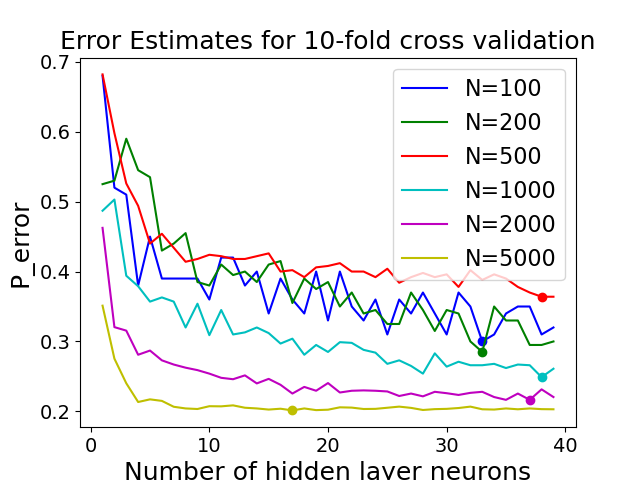

In [59]:
N_train_set = [100, 200, 500, 1000, 2000, 5000]
N_valid = 100000
K = 10 # Number of folds
n_sets = np.size(N_train_set)

fig, ax = plt.subplots()

n_perceptrons = 40

all_perceptrons = np.zeros((n_sets, n_perceptrons))
optimal_perceptrons = np.zeros(n_sets)
min_error = np.zeros(n_sets)


colors = 'bgrcmyk'

i= 0
for N_train in N_train_set:
    error_train_m, error_valid_m, perceptrons, optimal_perceptron = k_fold_analysis(N_train, N_valid, K, n_perceptrons)
    # plt.plot(perceptrons, error_train_m, label='D_train, N={}'.format(N_train))
    plt.plot(perceptrons, error_valid_m, label='N={}'.format(N_train), color=colors[i])
    plt.plot(optimal_perceptron, np.min(error_valid_m), marker = 'o', color=colors[i])
    optimal_perceptrons[i] = optimal_perceptron
    min_error[i] = np.min(error_valid_m)

    print('For N={}, optimal number of perceptrons is {}, producing p_error = {}'.format(N_train, optimal_perceptron, np.min(error_valid_m)))
    i +=1

plt.xlabel('Number of hidden layer neurons')
plt.ylabel('P_error')
plt.title('Error Estimates for 10-fold cross validation')
plt.legend()

Text(0.5, 1.0, 'Number of samples vs P_error')

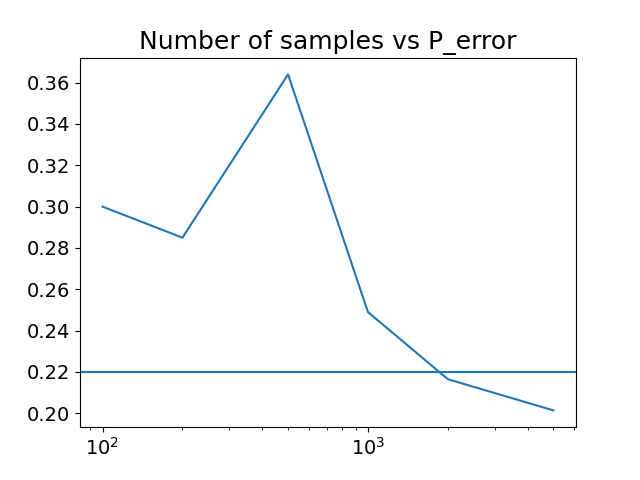

In [60]:
fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(N_train_set, min_error)
plt.axhline(y=p_optimal)
plt.title('Number of samples vs P_error')

Text(0, 0.5, 'Optimal number of perceptrons')

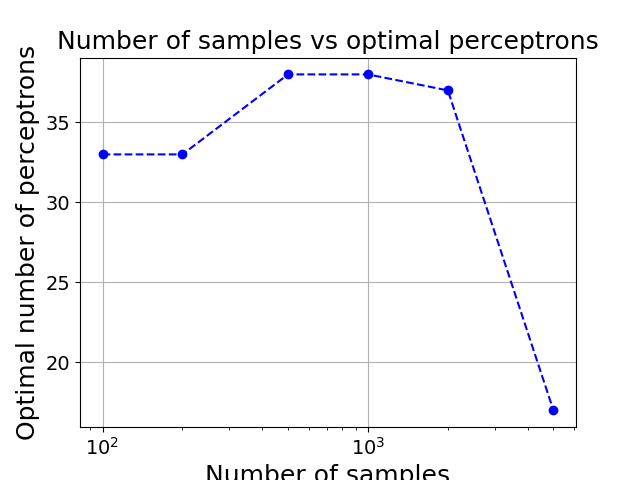

In [61]:
fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(N_train_set, optimal_perceptrons, '--bo')
plt.title('Number of samples vs optimal perceptrons')
plt.grid()
plt.xlabel('Number of samples')
plt.ylabel('Optimal number of perceptrons')

In [62]:
def final_model_gen(N_train, N_valid, K, n_hidden_neurons):
    X_train, y_train = generate_data_from_gmm(N_train, gmm_pdf)
    X_valid, y_valid = generate_data_from_gmm(N_valid, gmm_pdf)

    input_dim = X_train.shape[1]
    output_dim = C

    # Convert numpy structures to PyTorch tensors, as these are the data types required by the library
    X_train_k_tensor = torch.FloatTensor(X_train)
    y_train_k_tensor = torch.LongTensor(y_train)
    X_valid_k_tensor = torch.FloatTensor(X_valid)
    y_valid_k_tensor = torch.LongTensor(y_valid)

    # Create your dataset objects
    train_data = TensorDataset(X_train_k_tensor,  y_train_k_tensor) 
    test_data = TensorDataset(X_valid_k_tensor, y_valid_k_tensor) 

    train_dataloader = DataLoader(train_data, batch_size=500, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=64) # No need to shuffle...

    model = nn.Sequential(
        nn.Linear(input_dim, n_hidden_neurons),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons, output_dim),
        nn.LogSoftmax(dim=1)
    )
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    for t in range(num_epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        model_train_loader(model, train_dataloader, criterion, optimizer)
        model_test_loader(model, test_dataloader, criterion)

    # Trained model
    Z_probs_train = model(X_train_k_tensor).detach().numpy()
    Z_pred_train = np.argmax(Z_probs_train, 1)

    Z_probs_valid = model(X_valid_k_tensor).detach().numpy()
    Z_pred_valid = np.argmax(Z_probs_valid, 1)

    # Record error as well for this model and k-fold
    error = p_error(Z_pred_valid, y_valid)

    return error


Regenerate sets with optimal number of perceptrons:

In [63]:
error = np.zeros(n_sets)

i= 0
for N_train in N_train_set:
    n_hidden_neurons = int(optimal_perceptrons[i])

    # training 3 models using opt number of perceptrons:
    error_1 = final_model_gen(N_train, N_valid, K, n_hidden_neurons)
    error_2 = final_model_gen(N_train, N_valid, K, n_hidden_neurons)
    error_3 = final_model_gen(N_train, N_valid, K, n_hidden_neurons)
    
    error[i] = np.min([error_1, error_2, error_3]) #taking the min, prevents getting stuck in local minima

    print('For N={}, optimal number of perceptrons is {}, producing p_error = {}'.format(N_train, n_hidden_neurons, error[i]))
    i +=1

Confusion Matrix (rows: Predicted class, columns: True class):
[[18217  2611  9276    13]
 [  758 21230     5  2906]
 [10975   108 20492     0]
 [    2  6388     0  7019]]
Total Mumber of Misclassified Samples: 33042
Empirically Estimated Probability of Error: 0.3304
Confusion Matrix (rows: Predicted class, columns: True class):
[[26789  1150 15996     0]
 [ 1321 28799     6 10036]
 [ 1865     0 14038     0]
 [    0     0     0     0]]
Total Mumber of Misclassified Samples: 30374
Empirically Estimated Probability of Error: 0.3037
Confusion Matrix (rows: Predicted class, columns: True class):
[[ 8132   958  1985     2]
 [ 1411 27336    13  5240]
 [20297   317 27821     0]
 [    0  1627     0  4861]]
Total Mumber of Misclassified Samples: 31850
Empirically Estimated Probability of Error: 0.3185
For N=100, optimal number of perceptrons is 33, producing p_error = 0.30374
Confusion Matrix (rows: Predicted class, columns: True class):
[[19245  2123  8265     8]
 [ 1160 27854    11  9995]
 [ 

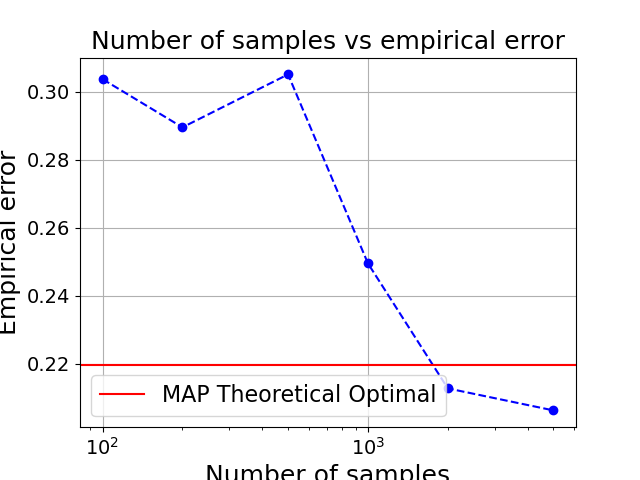

In [64]:
fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(N_train_set, error, '--bo')
plt.title('Number of samples vs empirical error')
plt.grid()
plt.xlabel('Number of samples')
plt.ylabel('Empirical error')
plt.axhline(y=p_optimal, color='r', label='MAP Theoretical Optimal')
plt.legend()
plt.show()